# Моделирование вкладов физических лиц

**Задача**: построить и описать модель, где целевой переменной (таргетом) являются помесячные изменения объемов рынка вкладов физических лиц РФ в рублях, которая будет объяснима с точки зрения экономической логики. Дополнительно требуется построить прогноз таргета на 01.2017 – 12.2017.

**Данные**: в файле xls представлены данные по изменениям объемов вкладов физических лиц в рублях в РФ, а также ставки по продукту, связанным с ним продуктам и макроэкономические показатели. В качестве объясняющих факторов можно использовать как показатели, представленные в базе, так и самостоятельно найденные показатели (например, на сайте Росстата или ЦБ). 

**Модель**: оценивание можно проводить с помощью любых моделей (методов и алгоритмов), однако, они должны показывать, как хорошее качество с точки зрения описания взаимосвязей, так и высокую предсказательную силу на будущий период. Так же модель должна давать согласующиеся с экономической логикой зависимости.

**Формат отчета**: Моделирование необходимо выполнить на python. На выходе нужно предоставить jupyter_notebook / rmarkdown / аналог с понятным описанием логики построения модели и интерпретацией результатов или аналог в doc / ppt / pdf / html

In [1]:
import re
import numpy as np
import pandas as pd
import scipy.stats as st

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *

from statsmodels. stats.diagnostic import het_white
from statsmodels.tsa.seasonal import STL
import statsmodels.formula.api as smf
import statsmodels.api as sm
import linearmodels.iv.model as lm

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
sns.set_theme()

In [2]:
def is_norm(x):
    if st.shapiro(x).pvalue<=0.05:
        return 'Распределение не нормальное'
    else:
        return 'Распределение нормальное'
    
def convert(pred, train):
    pred = pd.DataFrame(pred, columns=['now'])
    pred['previous'] = 0
    for i in pred.index:
        if i!=pd.to_datetime('2011-01-01'):
            pred.loc[i, 'previous'] = train.loc[i-pd.DateOffset(months=1)].target
        else: pred.loc[i, 'previous'] = 0
    return pred.now-pred.previous

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

### Данные

In [4]:
columns = ['date', 'target', 'bonds', 'key_rate', 'deposit_dol', 
           'deposit_rub', 'oil', 'cpi', 'm0', 'm2','exchange','salary']

df = pd.read_excel('BST_DataSet.xlsx', names = columns, index_col=0); del columns
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84 entries, 2011-01-01 to 2017-12-01
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   target       72 non-null     float64
 1   bonds        84 non-null     float64
 2   key_rate     84 non-null     float64
 3   deposit_dol  84 non-null     float64
 4   deposit_rub  84 non-null     float64
 5   oil          84 non-null     float64
 6   cpi          84 non-null     float64
 7   m0           84 non-null     float64
 8   m2           84 non-null     float64
 9   exchange     84 non-null     float64
 10  salary       84 non-null     int64  
dtypes: float64(10), int64(1)
memory usage: 7.9 KB


Данные не имеют пропусков (за исключением таргета), столбцы приведены к численному формату, в дополнительной обработке не нуждаются.

Данные содержат 84 наблюдения за период с янв. 2011 г. по дек. 2017 г.

## EDA

### $X_{1}$: Доходность ОФЗ по сроку до 1 года

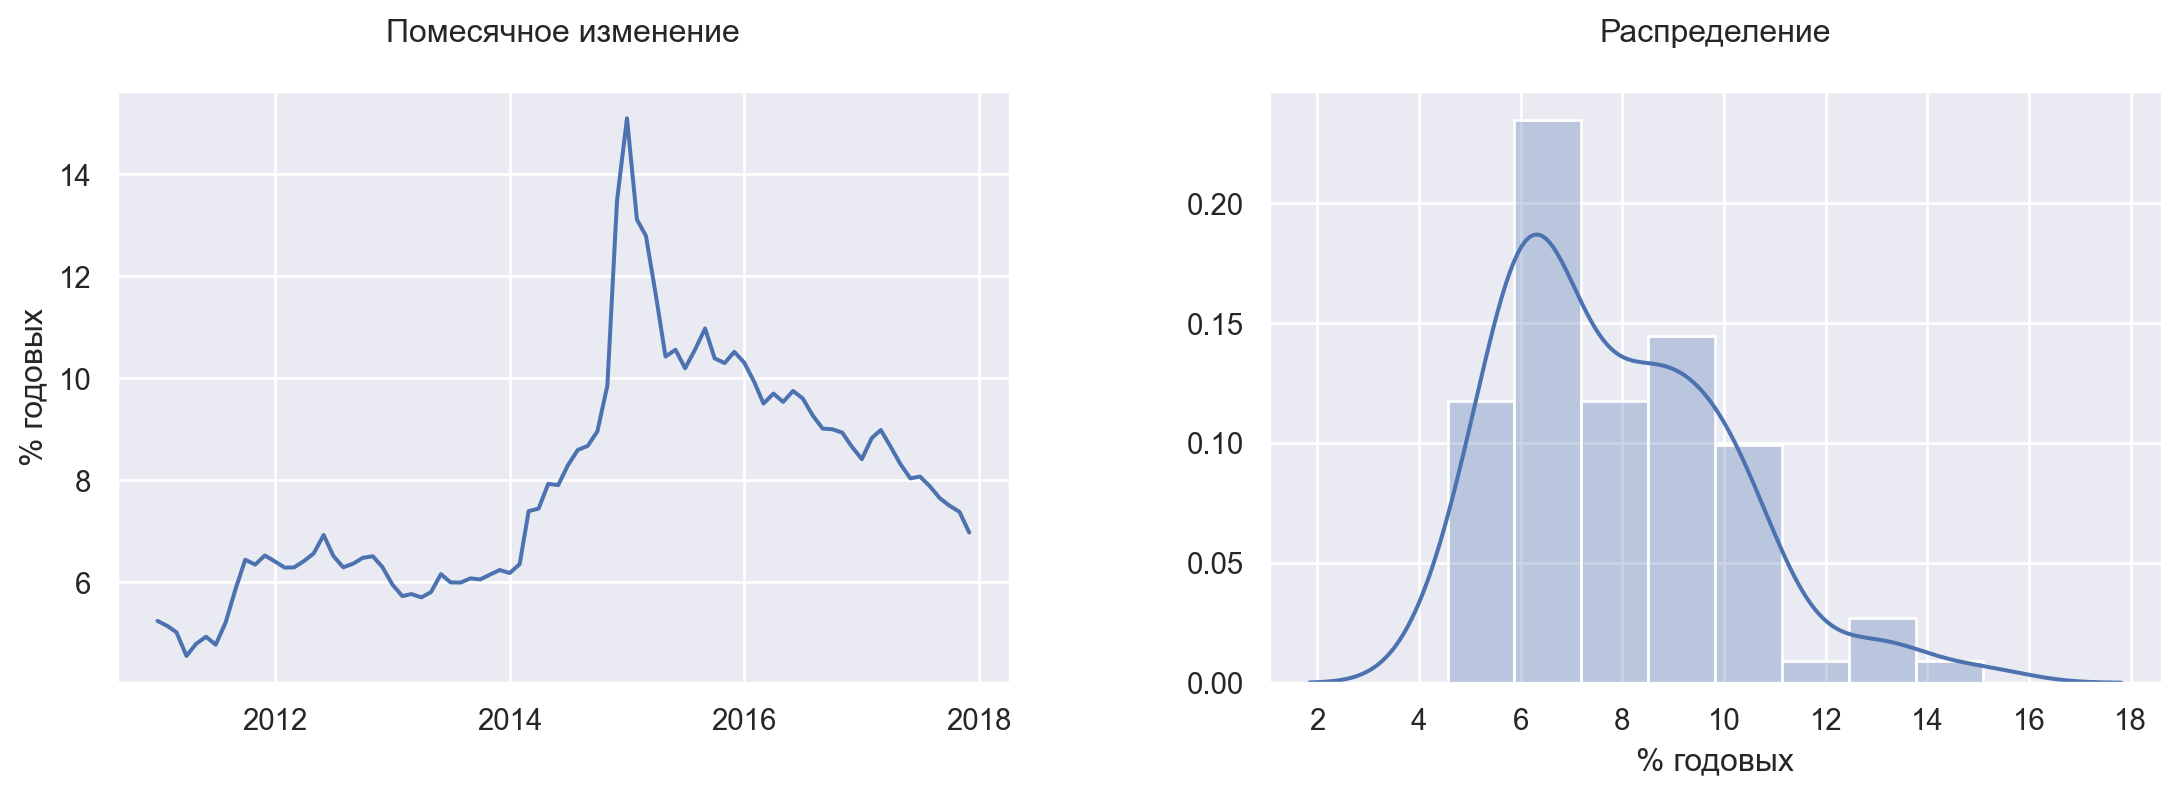

In [5]:
f = mpl.figure.Figure(figsize=(12, 4))
ax1, ax2 = f.subfigures(1, 2)

p1 = (
    so.Plot(x=df.index, y=df.bonds)
    .add(so.Lines())
    .label(title='Помесячное изменение\n', x='', y='% годовых')
    .save('plots/plot_3.png')
)

p2 = (
    so.Plot(df.bonds)
    .add(so.Bars(alpha=.3), so.Hist("density"))
    .add(so.Line(), so.KDE())
    .label(title='Распределение\n', x='% годовых', y='')
    .save('plots/plot_4.png')
)

p1.on(ax1).plot()
p2.on(ax2).plot()

In [6]:
print(is_norm(df.bonds))

Распределение не нормальное


% доходности гос. облигаций имеет неустойчивый рост с нач. 2011г. по сер. 2014г., в конце 2014 года происходит резкий скачок на ~6 %, и резкий спад в начале 2015 г. на ~3-4 %, далее происходит постепенный спад.

Описательные статиcтики:

In [7]:
df.describe().bonds.iloc[1:]

mean     7.875670
std      2.195040
min      4.558571
25%      6.228064
50%      7.475455
75%      9.332238
max     15.098421
Name: bonds, dtype: float64

### $X_{2}$ Ключевая ставка ЦБ

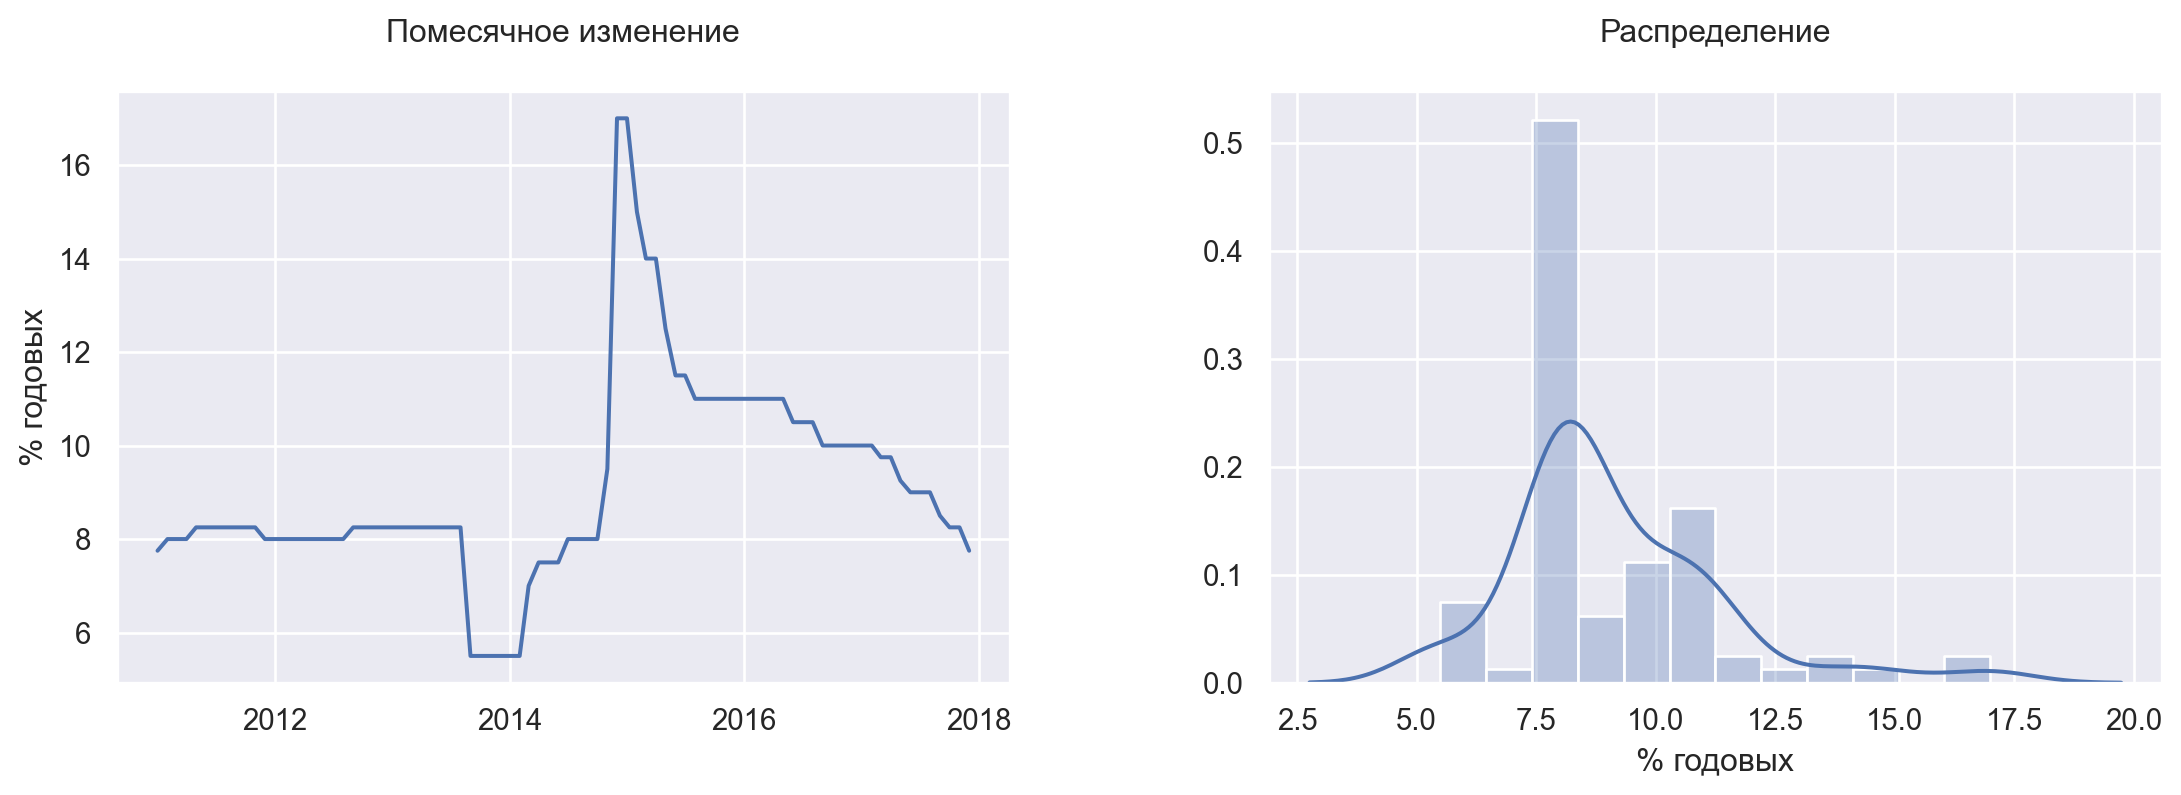

In [8]:
f = mpl.figure.Figure(figsize=(12, 4))
ax1, ax2 = f.subfigures(1, 2)

p1 = (
    so.Plot(x=df.index, y=df.key_rate)
    .add(so.Lines())
    .label(title='Помесячное изменение\n', x='', y='% годовых')
    .save('plots/plot_5.png')
)

p2 = (
    so.Plot(df.key_rate)
    .add(so.Bars(alpha=.3), so.Hist("density"))
    .add(so.Line(), so.KDE())
    .label(title='Распределение\n', x='% годовых', y='')
    .save('plots/plot_6.png')
)

p1.on(ax1).plot()
p2.on(ax2).plot()

In [9]:
print(is_norm(df.key_rate))

Распределение не нормальное


Ключевая ставка находится примерно на одном уровне (8 %) до сер. 2013 г., затем падает на 2% и возвращается к прежнему уровню в начале 2014 г. Так же как и доходность ОФЗ в конце 2014 г. происходит резкий скачок на ~ 8 % и падение с начала 2015 г. по конец 2017 г.

Описательные статистики:

In [10]:
print(df.describe().key_rate.iloc[1:])

mean     9.130952
std      2.214233
min      5.500000
25%      8.000000
50%      8.250000
75%     10.125000
max     17.000000
Name: key_rate, dtype: float64


### $X_{3}$ Средняя процентная ставка по вкладам ФЛ до 1 года (в долларах)

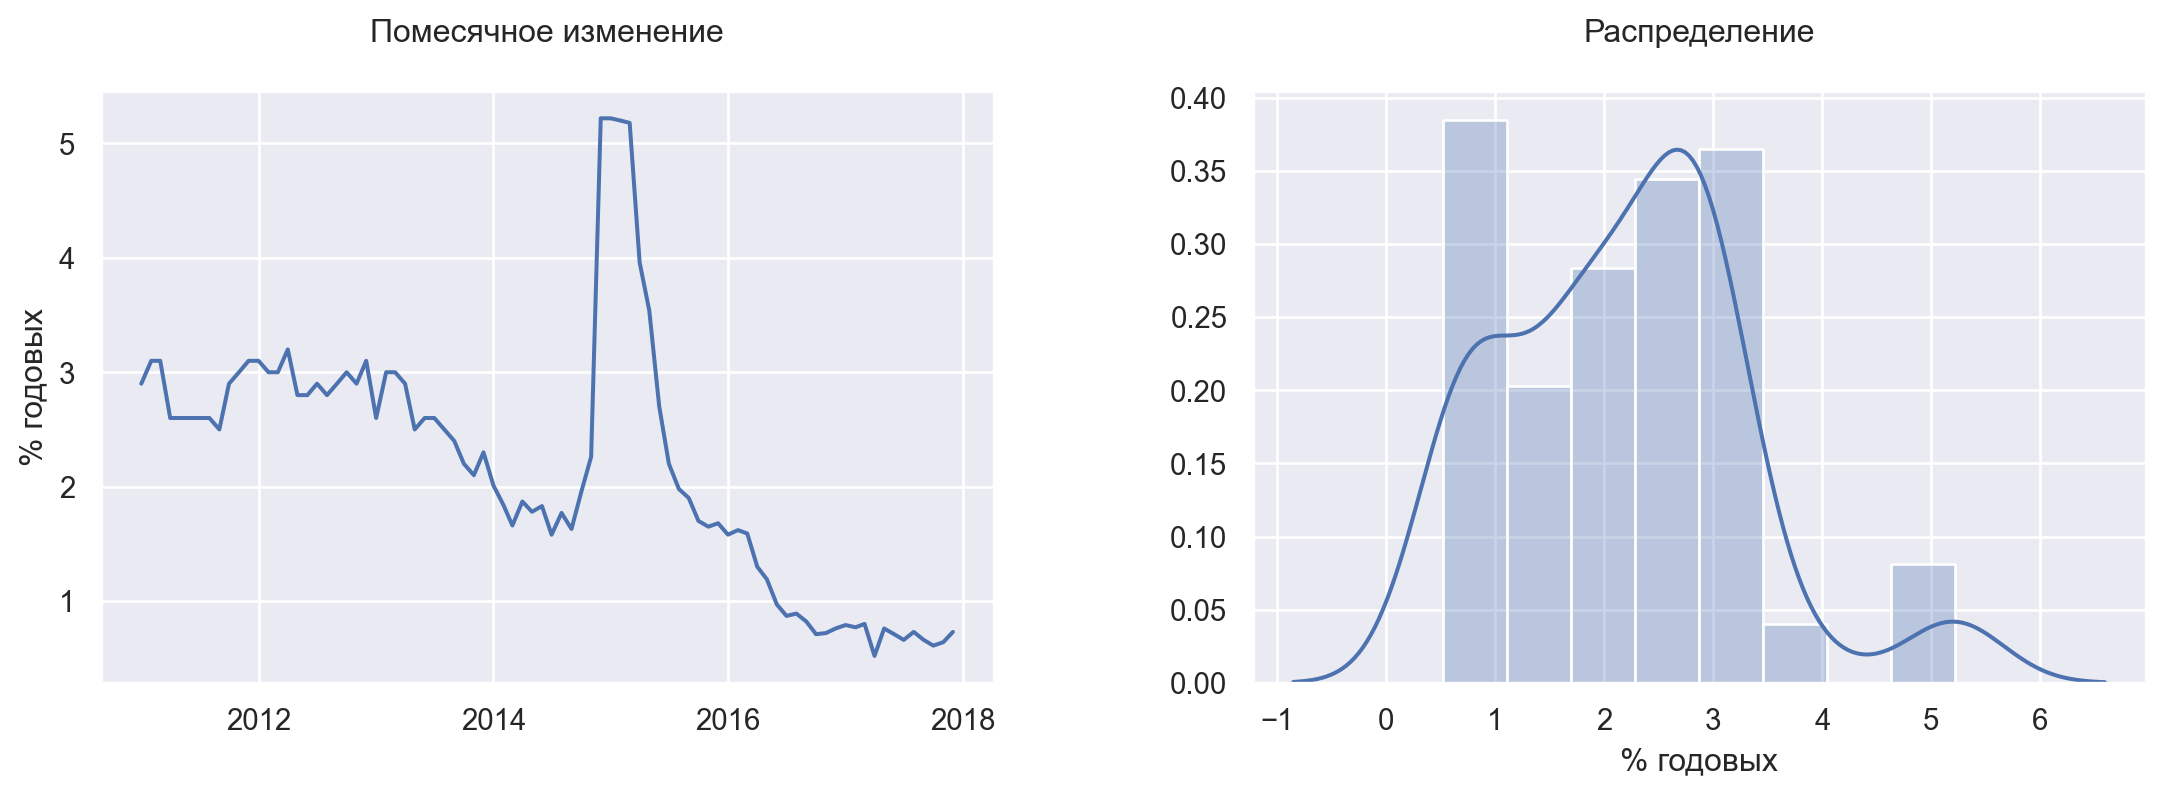

In [11]:
f = mpl.figure.Figure(figsize=(12, 4))
ax1, ax2 = f.subfigures(1, 2)

p1 = (
    so.Plot(x=df.index, y=df.deposit_dol)
    .add(so.Lines())
    .label(title='Помесячное изменение\n', x='', y='% годовых')
    .save('plots/plot_7.png')
)

p2 = (
    so.Plot(df.deposit_dol)
    .add(so.Bars(alpha=.3), so.Hist("density"))
    .add(so.Line(), so.KDE())
    .label(title='Распределение\n', x='% годовых', y='')
    .save('plots/plot_8.png')
)

p1.on(ax1).plot()
p2.on(ax2).plot()

In [12]:
print(is_norm(df.deposit_dol))

Распределение не нормальное


Средняя процентная ставка по вкладам ФЛ (в долларах) имеет нисходящую тенденцию до 2014 г., резкий скачок в начале 2015 г. до 5.2 % и падение к концу 2017 г. Средняя процентная ставка за весь период составляет 2.2 % (+- 1.1 %).

Описательная статистика:

In [13]:
df.describe().deposit_dol.iloc[1:]

mean    2.184643
std     1.108624
min     0.520000
25%     1.510000
50%     2.230000
75%     2.900000
max     5.220000
Name: deposit_dol, dtype: float64

### $X_{4}$ Средняя процентная ставка по вкладам ФЛ до 1 года (в рублях)

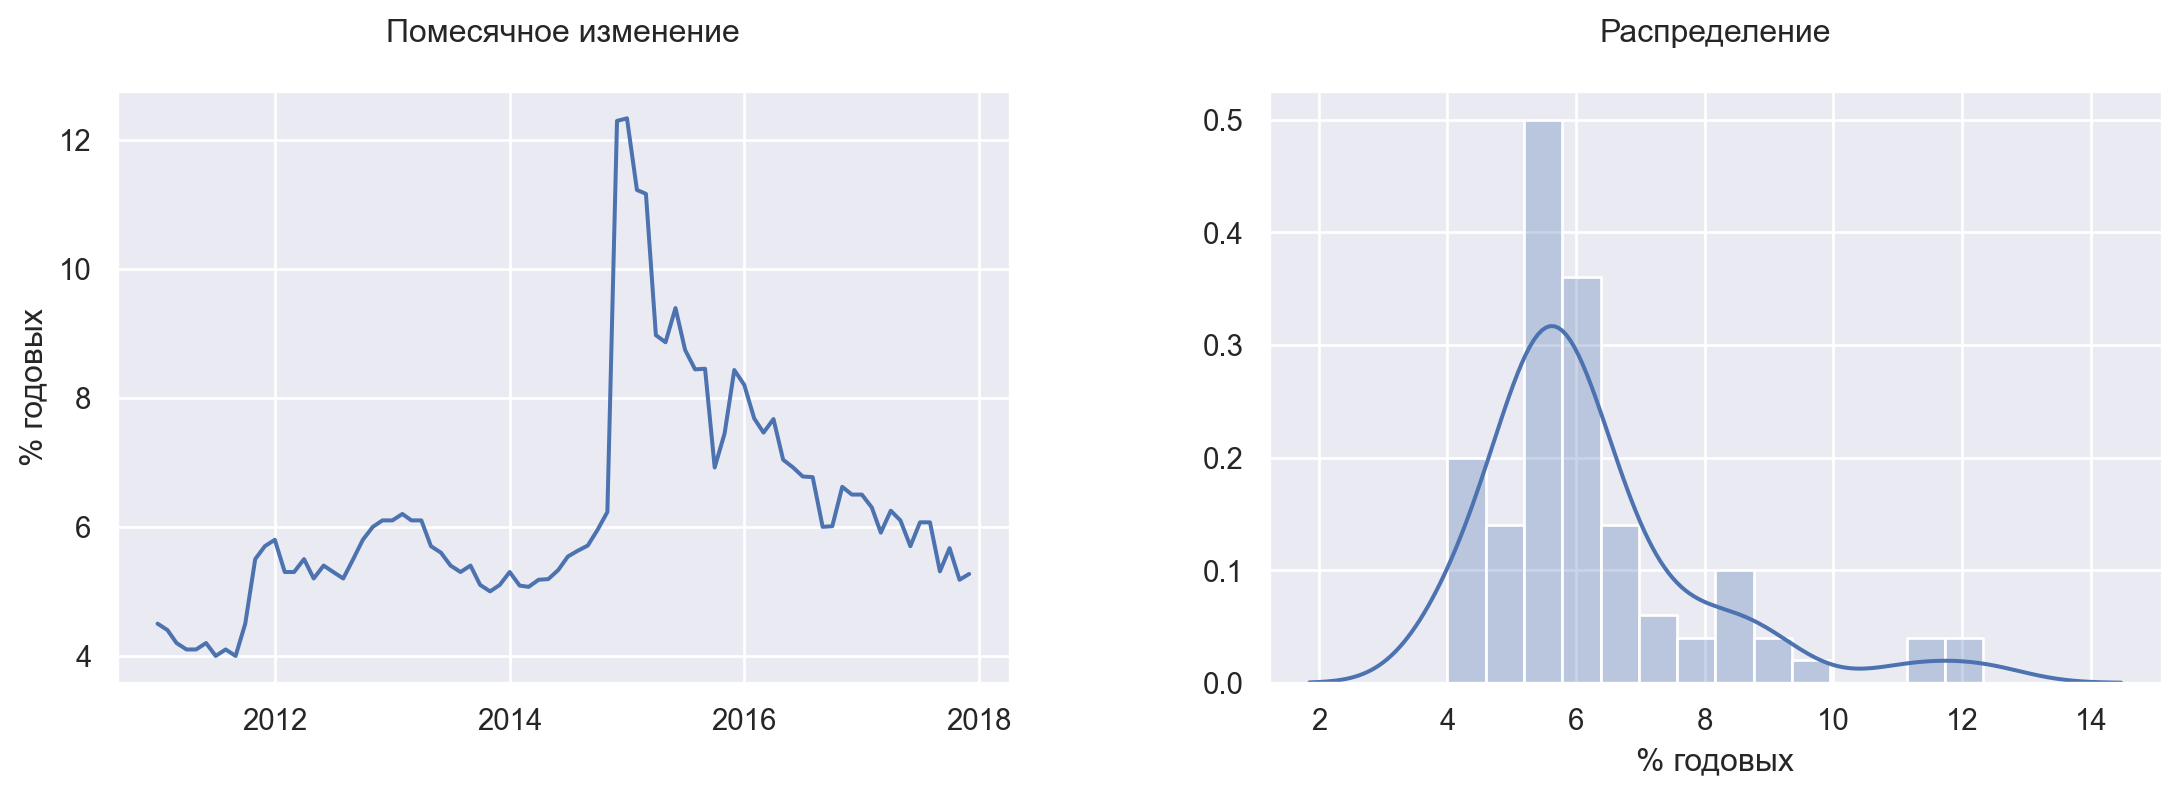

In [14]:
f = mpl.figure.Figure(figsize=(12, 4))
ax1, ax2 = f.subfigures(1, 2)

p1 = (
    so.Plot(x=df.index, y=df.deposit_rub)
    .add(so.Lines())
    .label(title='Помесячное изменение\n', x='', y='% годовых')
    .save('plots/plot_9.png')
)

p2 = (
    so.Plot(df.deposit_rub)
    .add(so.Bars(alpha=.3), so.Hist("density"))
    .add(so.Line(), so.KDE())
    .label(title='Распределение\n', x='% годовых', y='')
    .save('plots/plot_10.png')
)

p1.on(ax1).plot()
p2.on(ax2).plot()

In [15]:
print(is_norm(df.deposit_rub))

Распределение не нормальное


В целом распределение процентной ставки по вкладам ФЛ в рублях схоже с распределением ключевой ставки ЦБ и доходностью гос. облигаций.
Неустойчивый рост ставки в 2011-2014 гг., резккий рост в начале 2015г. на ~6 % (до 12.3 %) и падение к концу 2017 г.
Средняя ставка за весь вериод - 6.2 % (+- 1.7 %)

Описательная статистика:

In [16]:
df.describe().deposit_rub.iloc[1:]

mean     6.233929
std      1.733394
min      4.000000
25%      5.292500
50%      5.755000
75%      6.657500
max     12.330000
Name: deposit_rub, dtype: float64

### $X_{5}$ Нефть марки Юралс

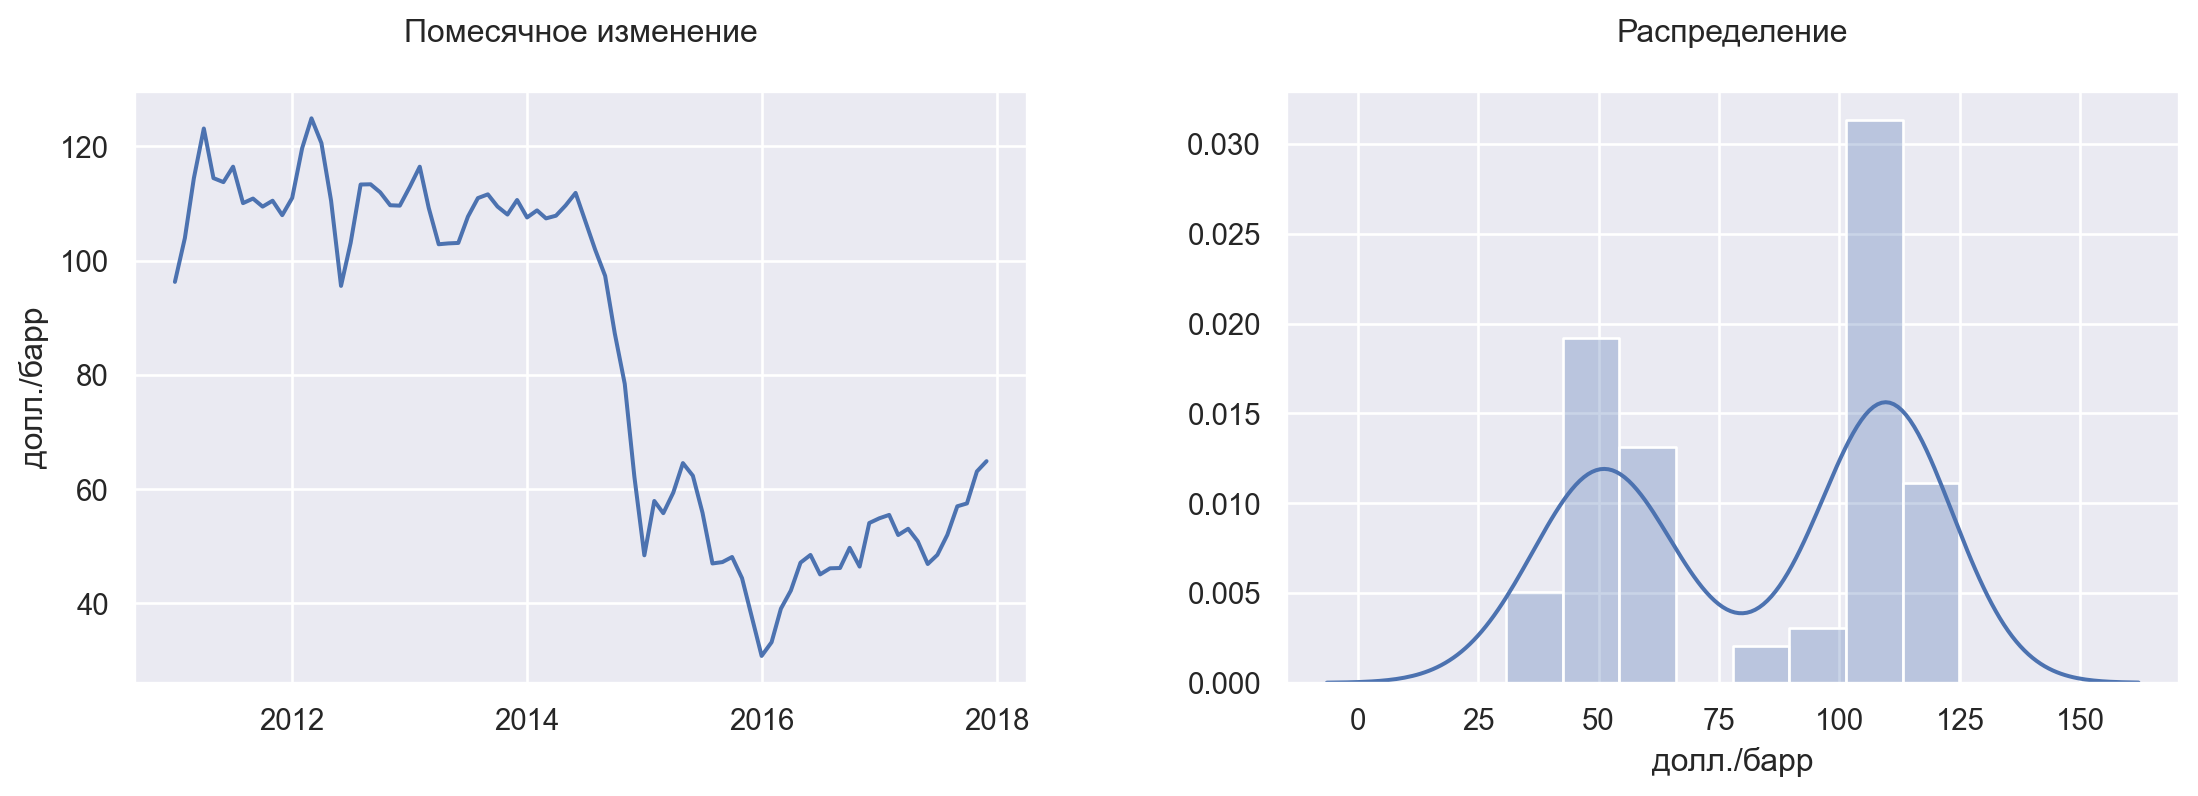

In [17]:
f = mpl.figure.Figure(figsize=(12, 4))
ax1, ax2 = f.subfigures(1, 2)

p1 = (
    so.Plot(x=df.index, y=df.oil)
    .add(so.Lines())
    .label(title='Помесячное изменение\n', x='', y='долл./барр')
    .save('plots/plot_11.png')
)

p2 = (
    so.Plot(df.oil)
    .add(so.Bars(alpha=.3), so.Hist("density"))
    .add(so.Line(), so.KDE())
    .label(title='Распределение\n', x='долл./барр', y='')
    .save('plots/plot_12.png')
)

p1.on(ax1).plot()
p2.on(ax2).plot()

In [18]:
print(is_norm(df.oil))

Распределение не нормальное


Цена на нефть марки Urals до событий 2014-2015 гг. колебалась на уровне ~ 110 долл. за баррель. С сер. 2014 г. до к. 2014г. происходит резкий спад до 48 долл. за баррель. В первом полугодии 2015 г. цена возрастает до 65 долл., но во втором полугоди снова падает достигая минимума в 31 долл. за баррель к янв. 2016 г. К концу 2017 г. цена на нефть постепенно возрастает.

Описательная статистика:

In [19]:
df.describe().oil.iloc[1:]

mean     83.118095
std      30.069987
min      30.800000
25%      51.992500
50%      99.630000
75%     110.185000
max     124.930000
Name: oil, dtype: float64

### $X_{6}$ Индекс потребительских цен

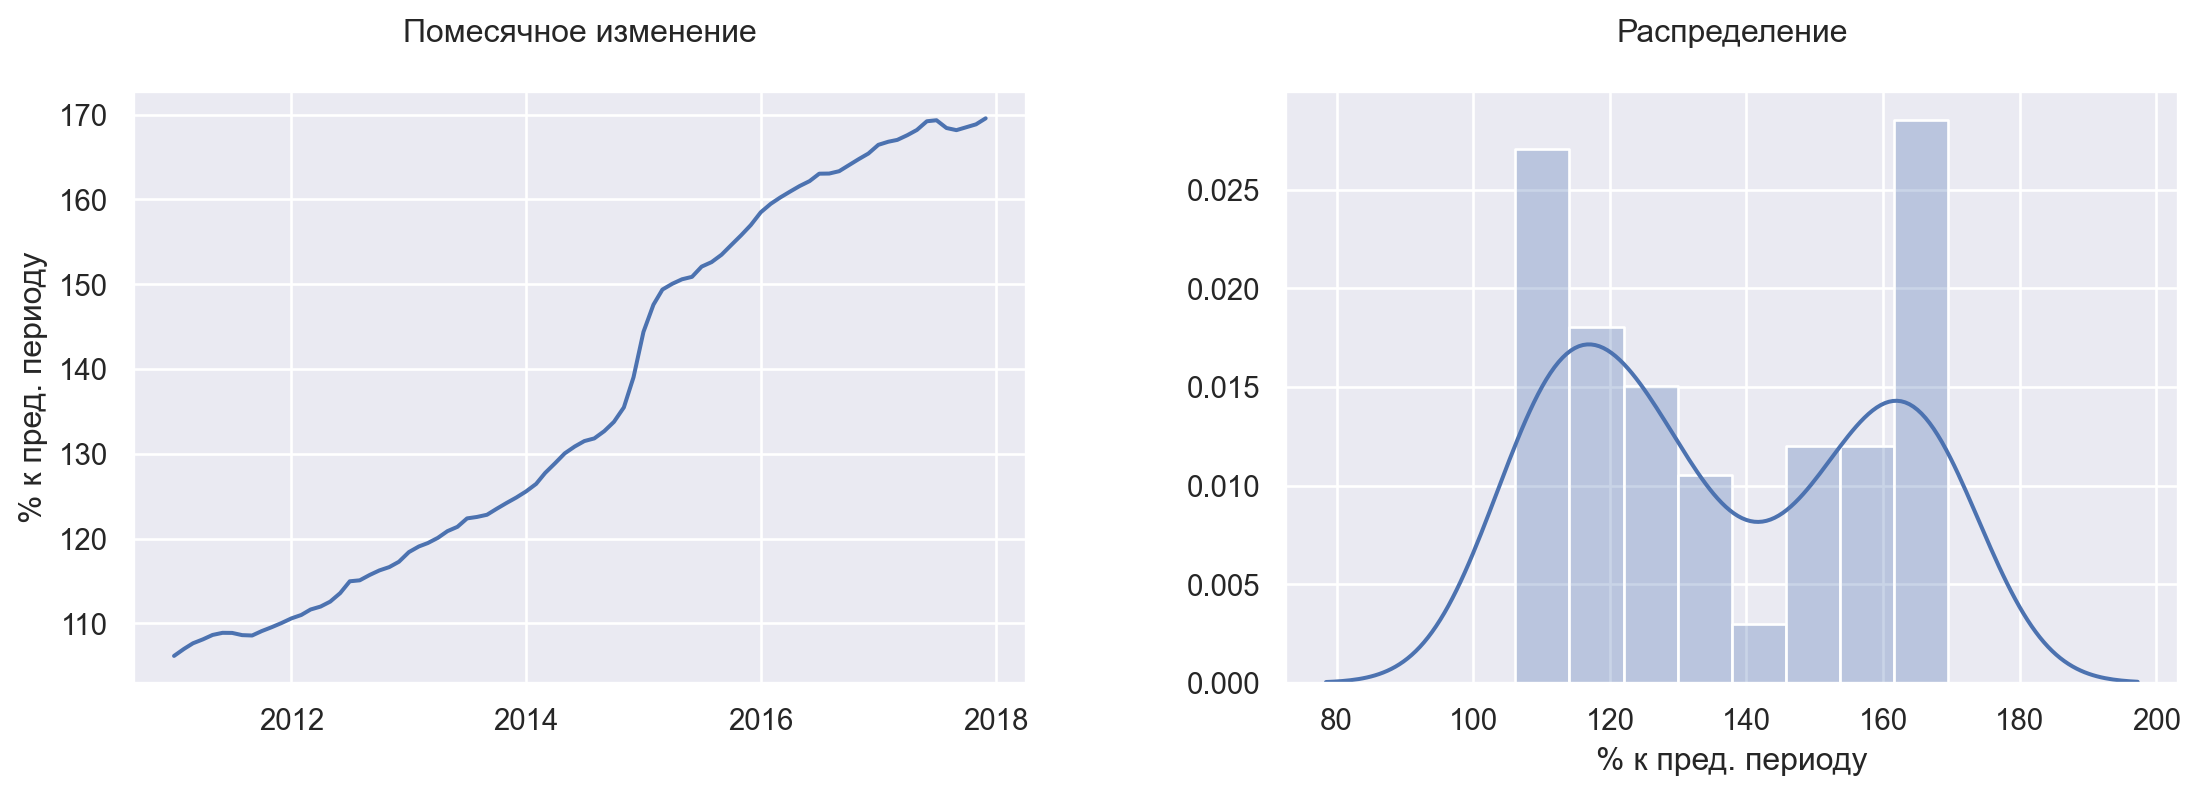

In [20]:
f = mpl.figure.Figure(figsize=(12, 4))
ax1, ax2 = f.subfigures(1, 2)

p1 = (
    so.Plot(x=df.index, y=df.cpi)
    .add(so.Lines())
    .label(title='Помесячное изменение\n', x='', y='% к пред. периоду')
    .save('plots/plot_13.png')
)

p2 = (
    so.Plot(df.cpi)
    .add(so.Bars(alpha=.3), so.Hist("density"))
    .add(so.Line(), so.KDE())
    .label(title='Распределение\n', x='% к пред. периоду', y='')
    .save('plots/plot_14.png')
)

p1.on(ax1).plot()
p2.on(ax2).plot()

In [21]:
print(is_norm(df.cpi))

Распределение не нормальное


За весь период ИПЦ имеет восходящую тенденцию. В среднем до конца 2014 г. рост составляет ~ 7-9 % в год. В конце 2014 г. - нач. 2015 г. скорость роста увеличилась примерно в 2 раза. Затем скорость снижается до прежнего уровня.

Описательные статистики:

In [22]:
df.describe().cpi.iloc[1:]

mean    136.725747
std      22.413867
min     106.171510
25%     116.118345
50%     131.183355
75%     160.386900
max     169.560950
Name: cpi, dtype: float64

### $X_{7}$ и $X_{8}$ Денежный агрегат М0 и M2

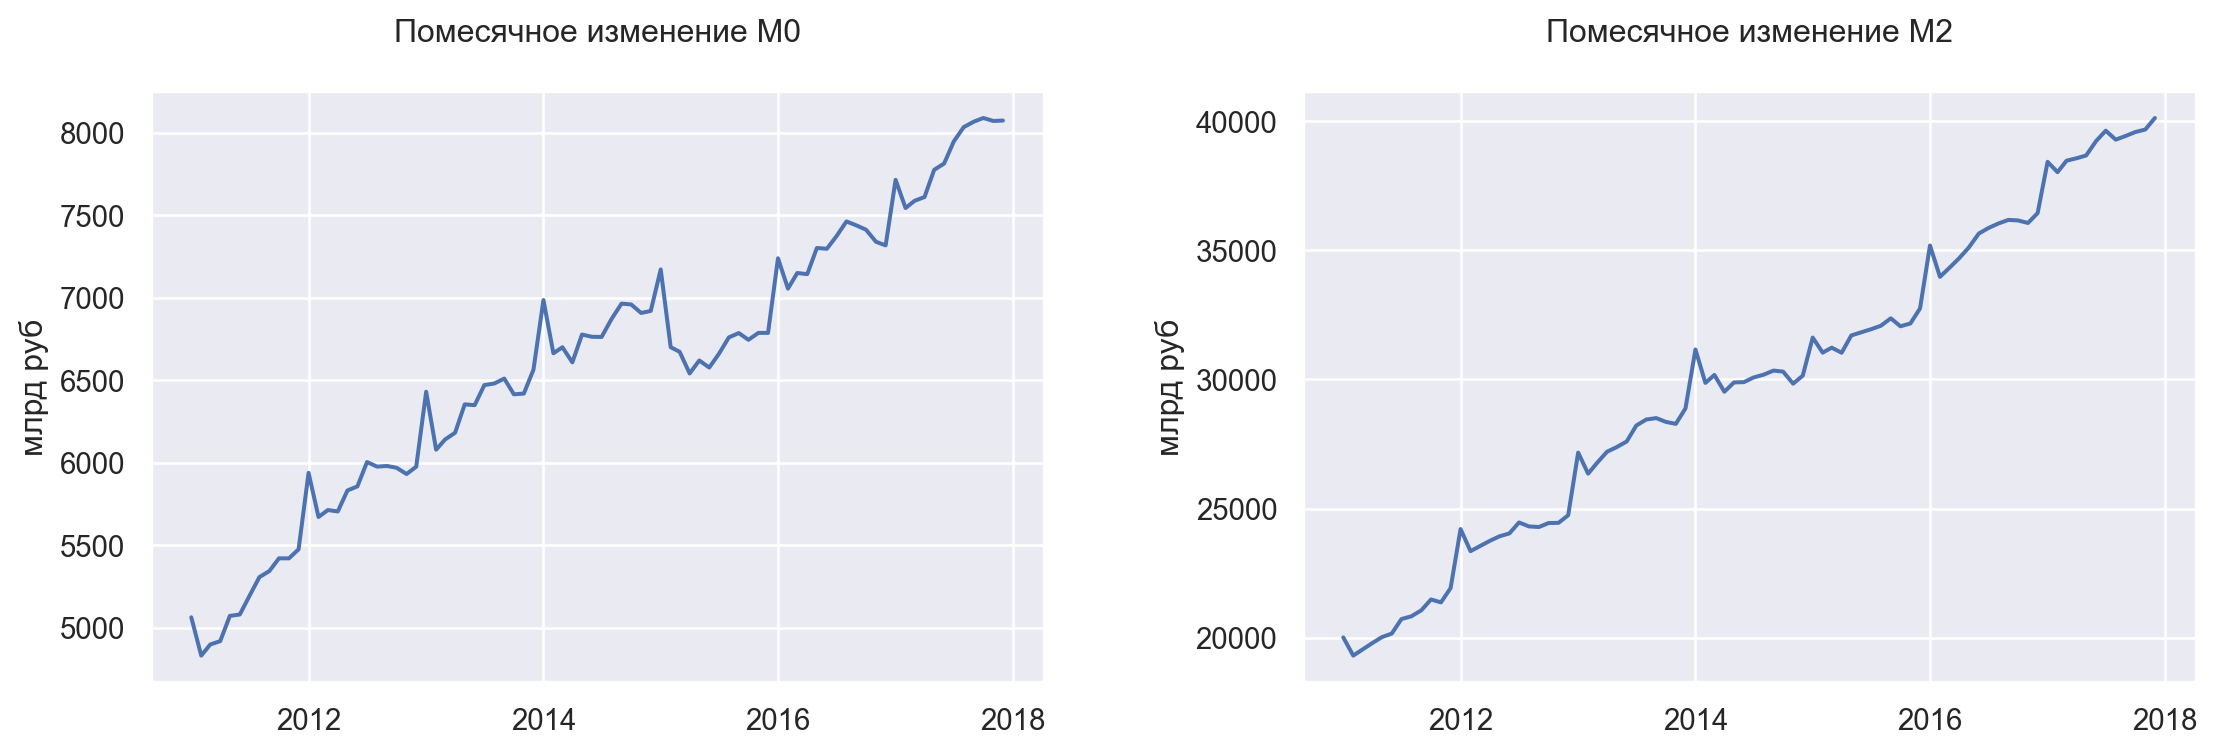

In [23]:
f = mpl.figure.Figure(figsize=(12, 4))
ax1, ax2 = f.subfigures(1, 2)

p1 = (
    so.Plot(x=df.index, y=df.m0)
    .add(so.Lines())
    .label(title='Помесячное изменение M0\n', x='', y='млрд руб')
    .save('plots/plot_15.png')
)

p2 = (
    so.Plot(x=df.index, y=df.m2)
    .add(so.Lines())
    .label(title='Помесячное изменение M2\n', x='', y='млрд руб')
    .save('plots/plot_17.png')
)

p1.on(ax1).plot()
p2.on(ax2).plot()

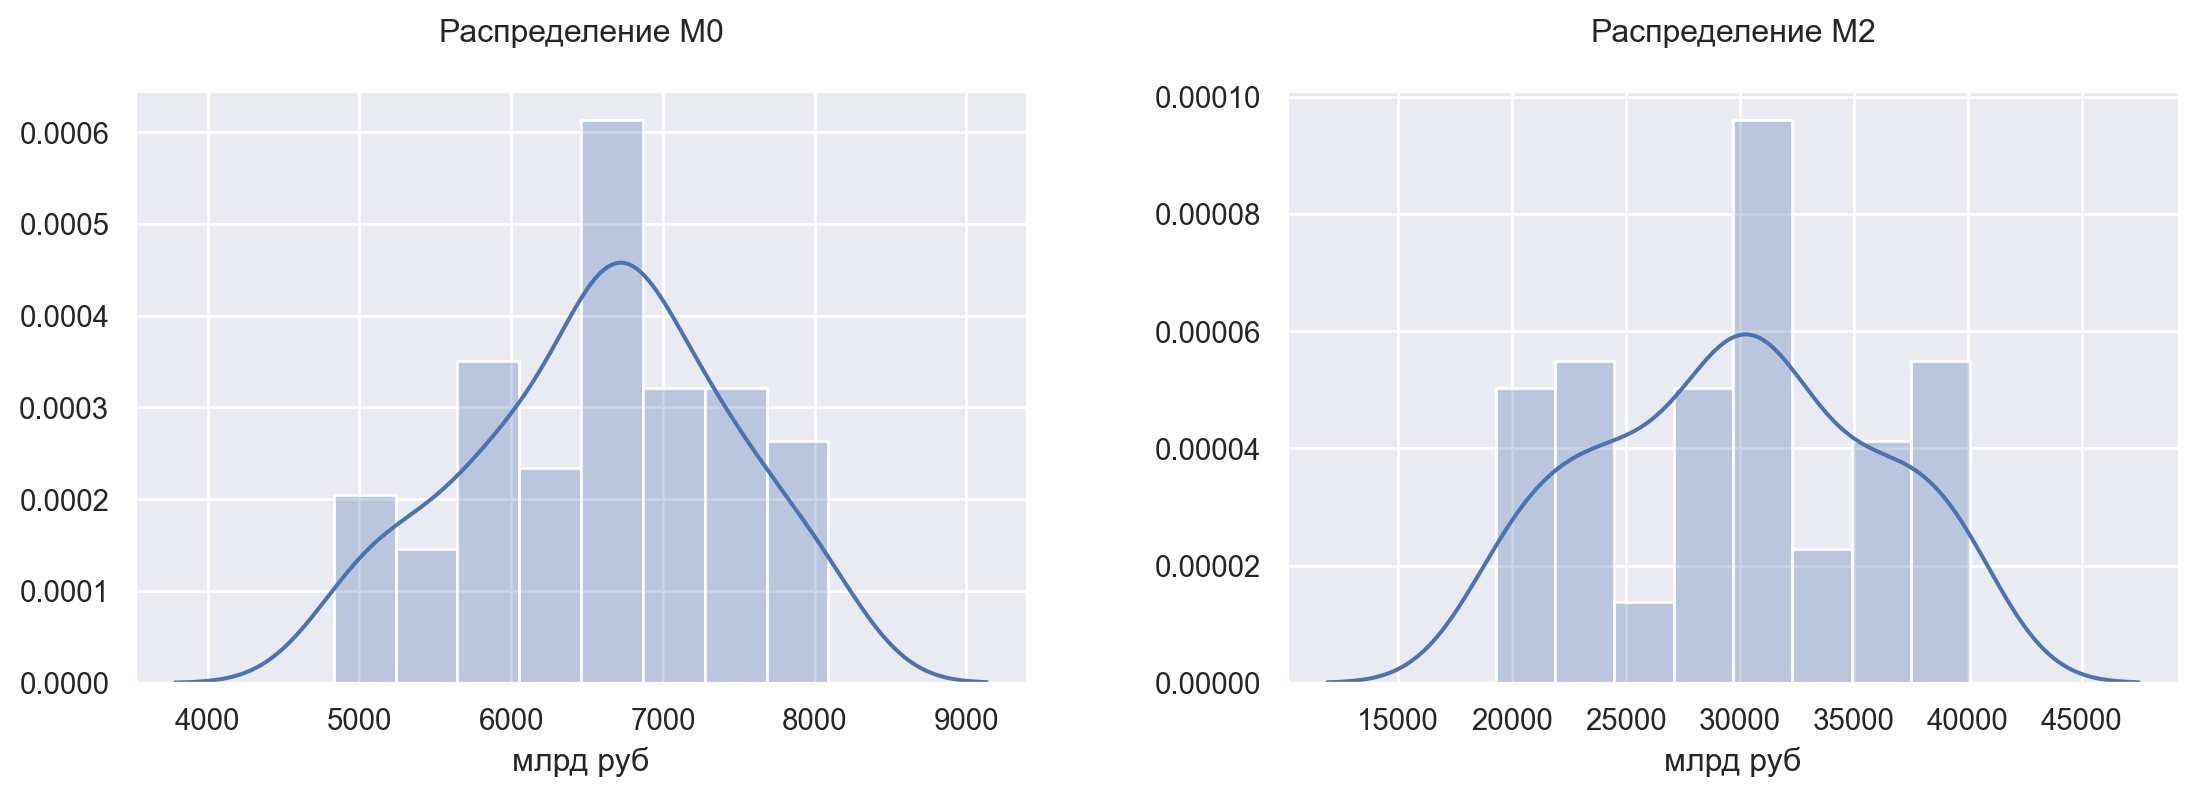

In [24]:
f = mpl.figure.Figure(figsize=(12, 4))
ax1, ax2 = f.subfigures(1, 2)

p1 = (
    so.Plot(df.m0)
    .add(so.Bars(alpha=.3), so.Hist("density"))
    .add(so.Line(), so.KDE())
    .label(title='Распределение M0\n', x='млрд руб', y='')
    .save('plots/plot_18.png')
)

p2 = (
    so.Plot(df.m2)
    .add(so.Bars(alpha=.3), so.Hist("density"))
    .add(so.Line(), so.KDE())
    .label(title='Распределение M2\n', x='млрд руб', y='')
    .save('plots/plot_18.png')
)

p1.on(ax1).plot()
p2.on(ax2).plot()

In [25]:
print(f'M0: {is_norm(df.m0)}')
print(f'M2: {is_norm(df.m2)}')

M0: Распределение нормальное
M2: Распределение не нормальное


В целом, в обоих показателях имеется восходящая тенденция и сезонность.

Обращение денежных масс в январе резко падает, а в декабре резко возрастает, в течение года этот показатель постепенно возрастает.

Примечательно, что состояние экономики в конце 2014 г. - начале 2015 г. оказало сильное влияние на обращение наличных денежных  средств (M0), тогда как на денежную массу М2 это оказало эффект меньше. Наблюдается антирост М0 и снижение роста М2 в 2015 г. по отношению к пред. году. После 2016 г. ситуация стабилизируется.

Описательные статистики:

In [26]:
df.describe()[['m0', 'm2']].iloc[1:]

m0            m2
mean  6589.289050  29838.955891
std    844.915477   5984.722501
min   4830.700000  19307.700000
25%   5976.075000  24443.050000
50%   6667.511360  30106.850000
75%   7188.388730  34793.453636
max   8089.527215  40114.408278

### $X_{9}$ Курс доллара к рублю

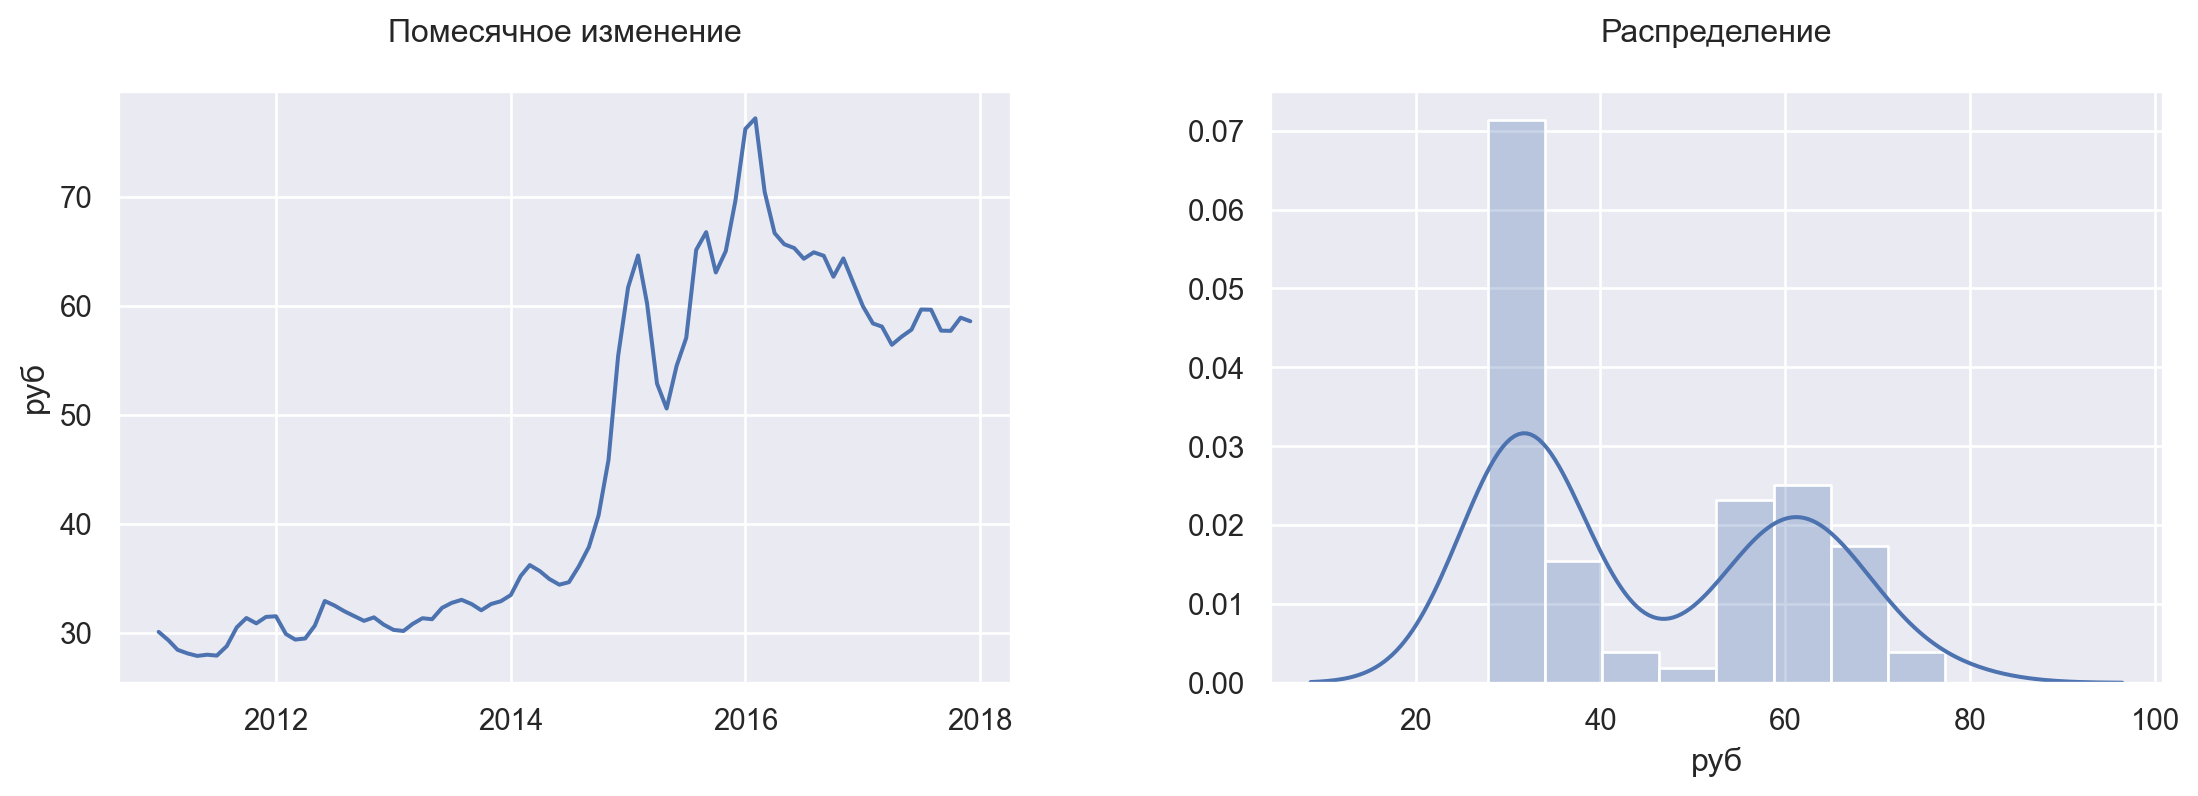

In [27]:
f = mpl.figure.Figure(figsize=(12, 4))
ax1, ax2 = f.subfigures(1, 2)

p1 = (
    so.Plot(x=df.index, y=df.exchange)
    .add(so.Lines())
    .label(title='Помесячное изменение\n', x='', y='руб')
    .save('plots/plot_21.png')
)

p2 = (
    so.Plot(df.exchange)
    .add(so.Bars(alpha=.3), so.Hist("density"))
    .add(so.Line(), so.KDE())
    .label(title='Распределение\n', x='руб', y='')
    .save('plots/plot_22.png')
)

p1.on(ax1).plot()
p2.on(ax2).plot()

In [28]:
print(is_norm(df.exchange))

Распределение не нормальное


Курс доллара к рублю до 2014 г. находился примерно на уровне в 31 руб., далее резко возрастает до 65 рублей в фев. 2015 г. К середине 2015г. наблюдается спад, а затем снова резкий рост до 77 руб в фев. 2016 г., после 2016 г. ситуация стабилизируется.

Описательные статистики:

In [29]:
df.describe().exchange.iloc[1:]

mean    45.288690
std     15.539177
min     27.870000
25%     31.345000
50%     35.885000
75%     59.742500
max     77.220000
Name: exchange, dtype: float64

### $X_{10}$ Номинальная средняя з/п

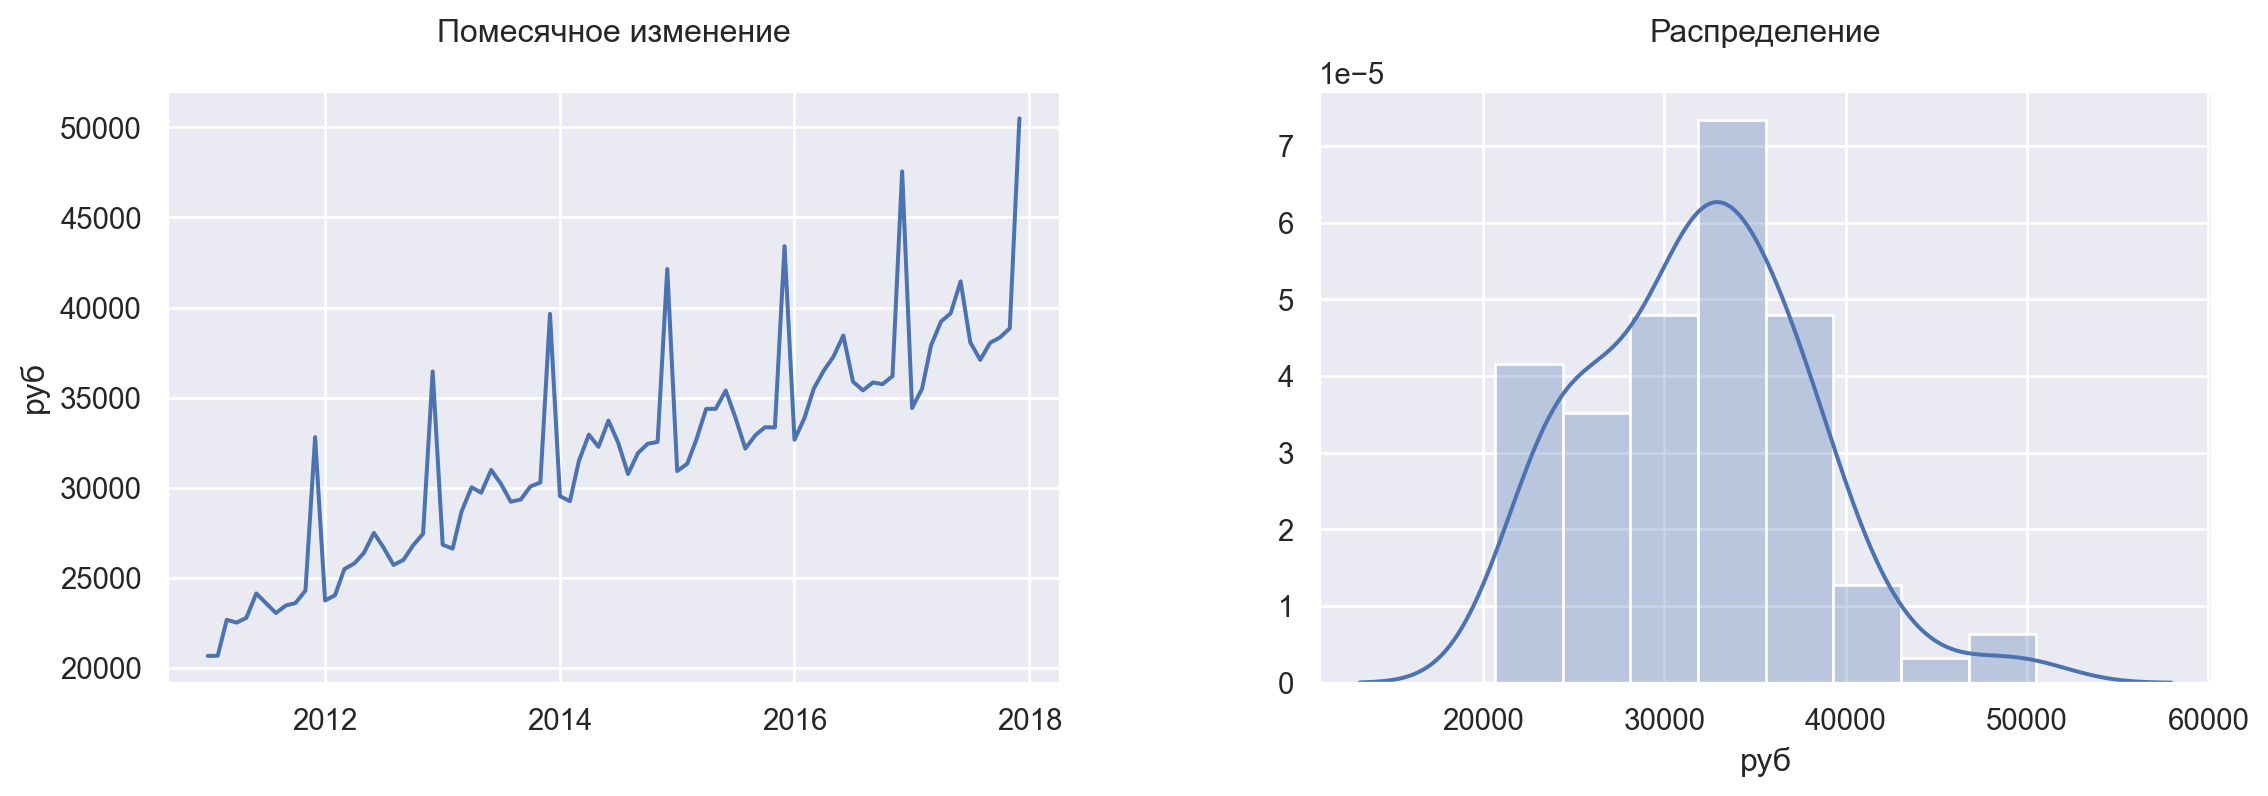

In [30]:
f = mpl.figure.Figure(figsize=(12, 4))
ax1, ax2 = f.subfigures(1, 2)

p1 = (
    so.Plot(x=df.index, y=df.salary)
    .add(so.Lines())
    .label(title='Помесячное изменение\n', x='', y='руб')
    .save('plots/plot_23.png')
)

p2 = (
    so.Plot(df.salary)
    .add(so.Bars(alpha=.3), so.Hist("density"))
    .add(so.Line(), so.KDE())
    .label(title='Распределение\n', x='руб', y='')
    .save('plots/plot_24.png')
)

p1.on(ax1).plot()
p2.on(ax2).plot()

In [31]:
print(is_norm(df.salary))

Распределение нормальное


Уровень заработной платы также имеет возрастающую тенденцию и сезонность.

Так, средний прирост зарплаты составляет примерно 2-3 тыс. руб в год .
В январе самый низкий уровень зар. платы, в декабре - самый высокий. Прирост зар. платы в декабре самый большой.

Описательные статистики:

In [32]:
df.describe().salary.iloc[1:]

mean    31877.130952
std      6029.179510
min     20669.000000
25%     26830.750000
50%     32355.500000
75%     35772.500000
max     50500.000000
Name: salary, dtype: float64

### $Y$: Прирост вкладов физических лиц в рублях (млн руб)

Зависимую переменную рассмотрим более подробно.

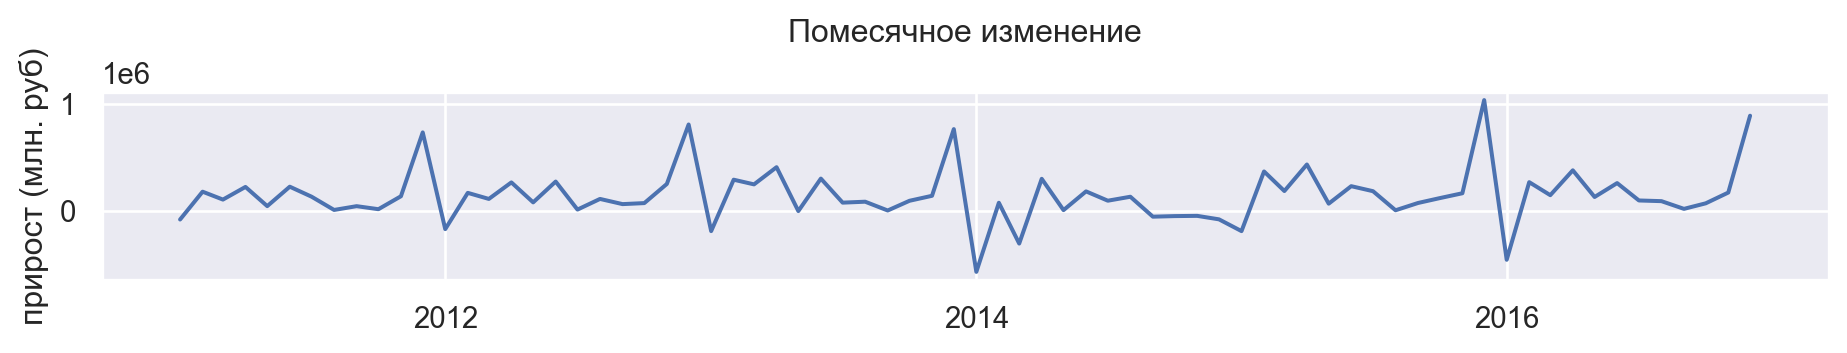

In [33]:
(
    so.Plot(x=df.index, y=df.target)
    .add(so.Lines())
    .label(title='Помесячное изменение\n', x='', y='прирост (млн. руб)')
    .layout(size=(10,2))
    .save('plots/plot_1.png')
)

На данном графике видно наличие годовой сезонности прироста вкладов.

Для уверенности проверим автокорреляционной функцией:

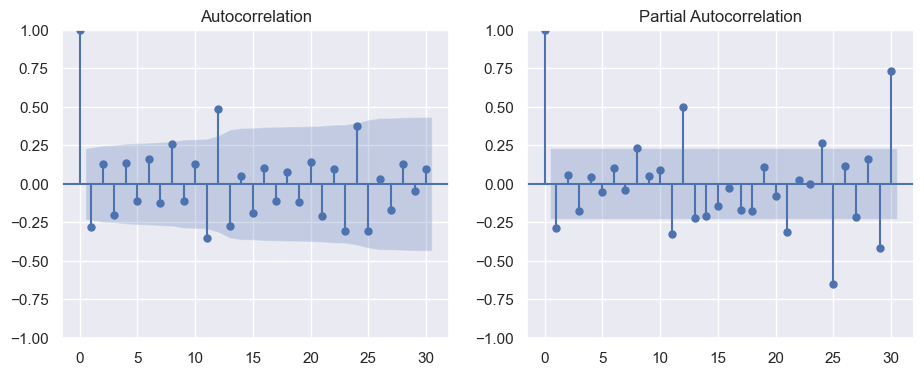

In [34]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,4))

acf = plot_acf(df.target.dropna(), ax=ax1, lags=30)
pacf = plot_pacf(df.target.dropna(), ax=ax2, lags=30)

Годовая сезонность подтверждается.

Описательные статистики:

In [35]:
df.describe().target.iloc[1:]

mean    1.466405e+05
std     2.593857e+05
min    -5.674480e+05
25%     1.949025e+04
50%     1.129245e+05
75%     2.360528e+05
max     1.034556e+06
Name: target, dtype: float64


Давайте разложим переменную на сезонность, тренд и остатки:

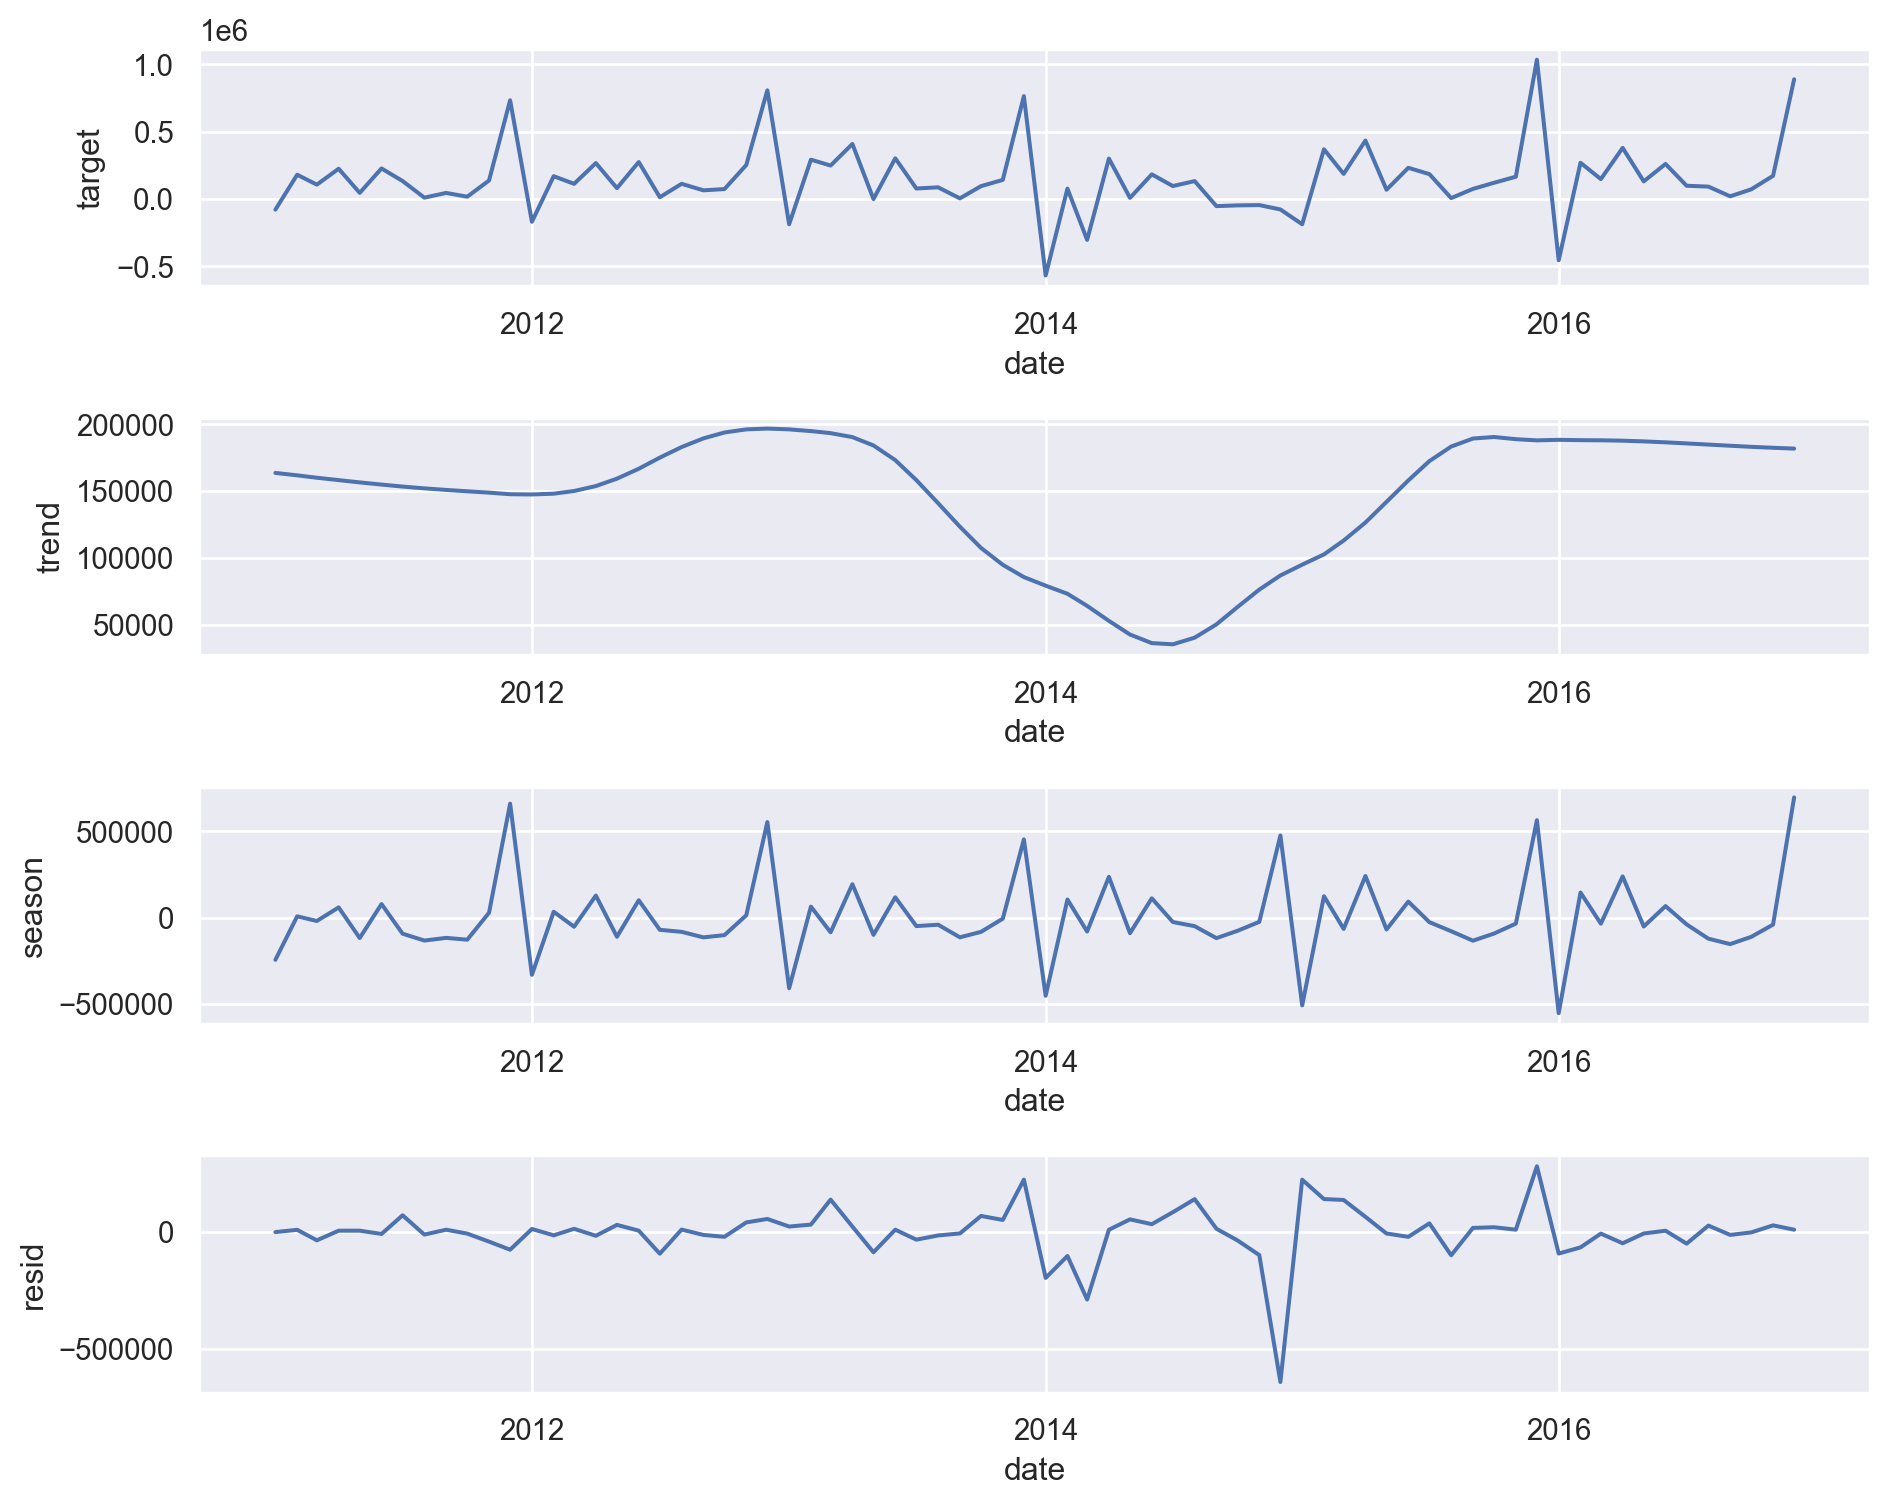

In [36]:
stl = STL(df.target.dropna()).fit()

(
    so.Plot()
    .pair(x=[stl.observed.index, stl.trend.index, stl.seasonal.index, stl.resid.index],
          y=[stl.observed, stl.trend, stl.seasonal, stl.resid],
          cross=False, wrap=1)
    .add(so.Lines())
    .layout(size=(10,8))
)

- На графике сезонности видно, как изменяется прирост вкладов в зависимости от месяца. Январь является месяцем с самым низким показателем, декабрь является месяцем с самым высоким.
- Поскольку переменная фактически является дифференциалом, то теоретически тренд должен отсутствовать, а линия тренда должна быть горизонтально прямой. Однако полученная линия тренда изменяется в период с 2013г. по 2016 г.
- На графике остатков изображены ошибки модели сезонности и тренда. Как видно, в период 2014-2015 гг. ошибки наиболее всего отклонялись от 0.

Так как линия тренда и отстатков наиболее изменяется в период, когда произошел экономический кризис, то можно предположить, что
на графике сезонности продемонстрирована функция прироста вкладов без влияния на нее внешних факторов. В свою очередь тренд и остатки в совокупности показывают то, насколько влияют макроэкономические факторы на прирост числа вкладов.

Данная переменная проиллюстрирована на след. графике:

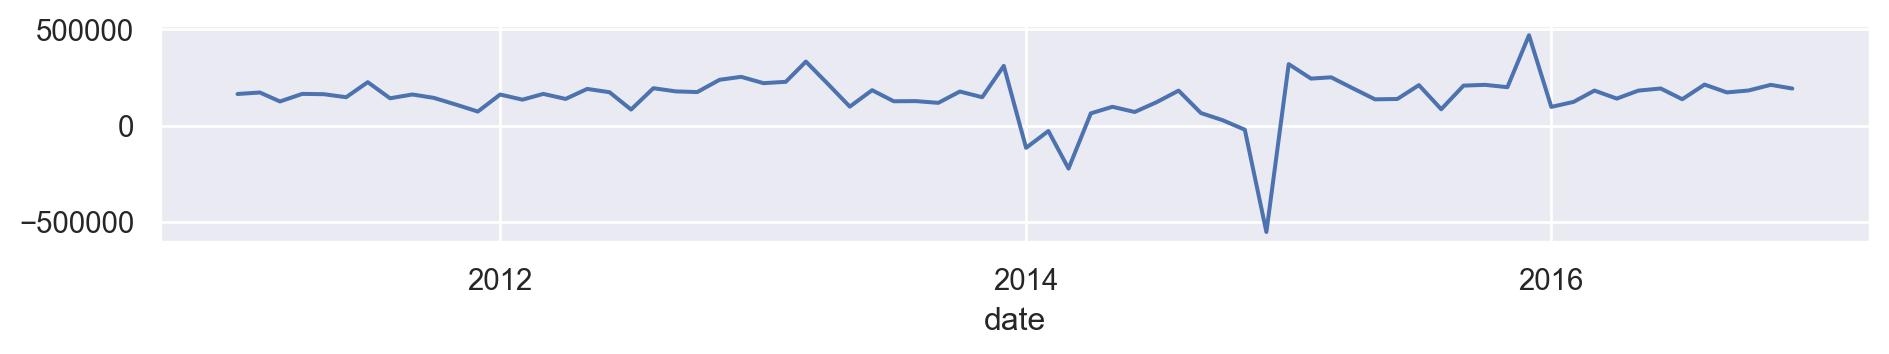

In [37]:
so.Plot(x=stl.trend.index,y=stl.resid+stl.trend).add(so.Lines()).layout(size=(10,2)).label(title='', y='')

### Взаимосвязь таргета с предикторами

In [38]:
# так как таргет показывает прирост за месяц, а не на первое число месяца, 
# то некоторые переменные приходится сдвигать на один месяц назад.
# переменные, которые подвергнулись изменению, выбраны эмпирически

target = pd.DataFrame({
                       'target_resid': stl.resid+stl.trend,
                       'target_season': stl.seasonal,
                       'inflation': df.cpi.diff().shift(-1),
                       'bonds_dif': df.bonds.diff(),
                       'key_rate_dif': df.key_rate.diff(),
                       'deposit_dol_dif': df.deposit_dol.diff(),
                       'deposit_rub_dif': df.deposit_rub.diff(),
                       'oil_dif': (df.oil.diff()*100)/df.oil,
                       'exchange_dif': (df.exchange.diff()*100)/df.exchange,
                       'm0_dif': df.m0.diff().shift(-1),
                       'm2_dif': df.m2.diff().shift(-1),
                       'salary_dif': df.salary.diff(),
                      })

target = target.join(df)
to_shift = ['bonds', 'key_rate', 'deposit_dol', 'deposit_rub', 'oil', 'exchange', 'm0', 'm2']
target[to_shift] = target[to_shift].shift(-1)


target.fillna({'inflation':0.3, 'm2_dif': 2327.80, 'm0_dif': 372.10, 'm2':42442.2, 'm0':8446,
               'key_rate':7.75, 'exchange': 56.7875, 'oil': 67.96, 'deposit_rub': 5.225000, 
               'deposit_dol': 0.685000, 'bonds': 7.179762}, inplace=True)

rel_target = target.dropna()

sc = StandardScaler().fit(rel_target)
rel_target = pd.DataFrame(sc.transform(rel_target), columns=rel_target.columns, index=rel_target.index)

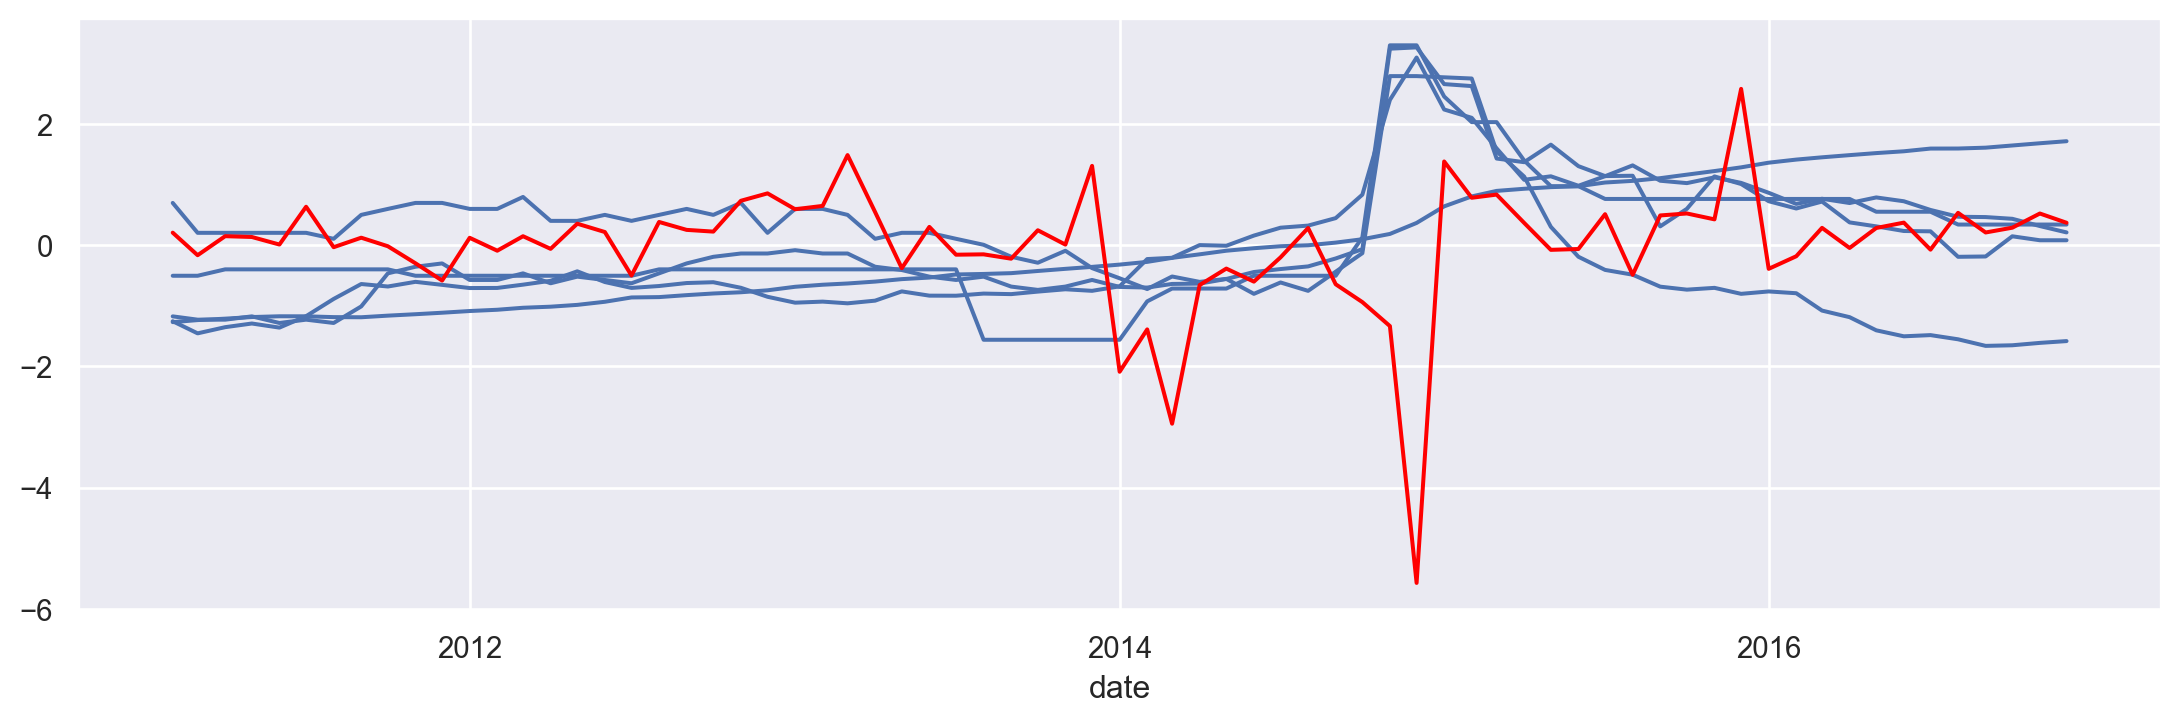

In [39]:
f = mpl.figure.Figure(figsize=(14, 4))
so.Plot().on(f).plot()
ax = f.axes[0]

so.Plot(x=rel_target.index,y=rel_target.cpi).add(so.Lines()).on(ax).plot() # color='red'
so.Plot(x=rel_target.index,y=rel_target.bonds).add(so.Lines()).on(ax).plot() # color='green'
so.Plot(x=rel_target.index,y=rel_target.key_rate).add(so.Lines()).on(ax).plot() # color='yellow'
so.Plot(x=rel_target.index,y=rel_target.deposit_dol).add(so.Lines()).on(ax).plot() # color='orange'
so.Plot(x=rel_target.index,y=rel_target.deposit_rub).add(so.Lines()).on(ax).plot() # color='brown'
(
    so.Plot(x=rel_target.index,y=rel_target.target_resid)
    .add(so.Lines(color='red'))
    .label(title='', y='')
    .layout(size=(10,2))
    .on(ax)
    .plot()
)

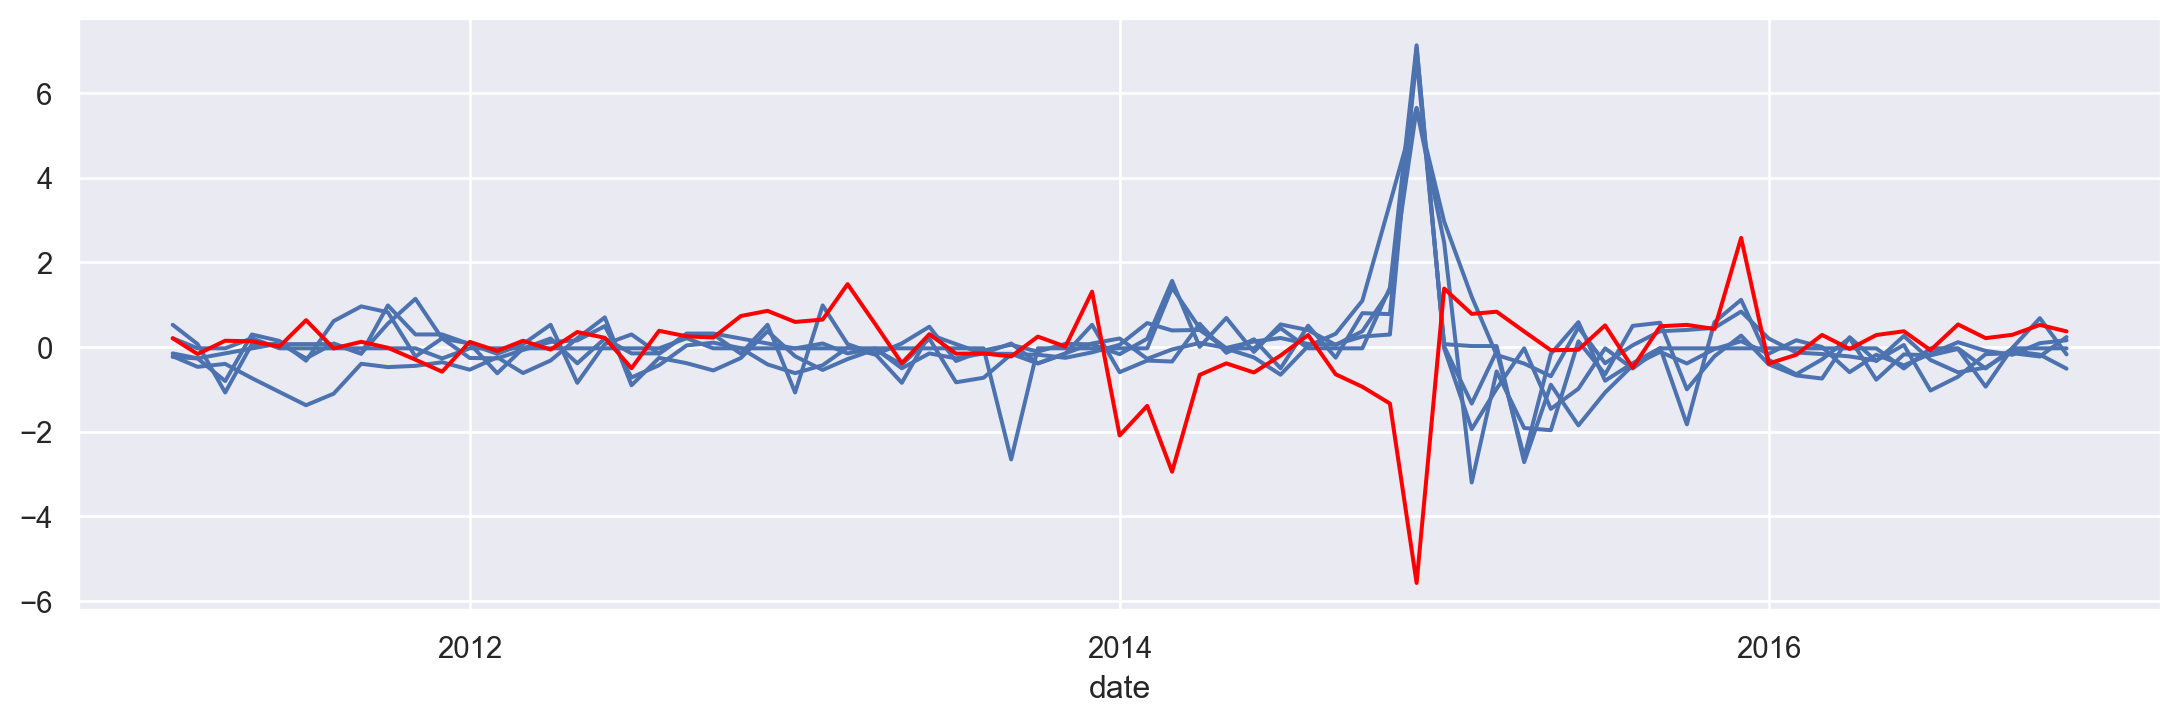

In [40]:
f = mpl.figure.Figure(figsize=(14, 4))
so.Plot().on(f).plot()
ax = f.axes[0]

so.Plot(x=rel_target.index,y=rel_target.inflation).add(so.Lines()).on(ax).plot() # color='red'
so.Plot(x=rel_target.index,y=rel_target.bonds_dif).add(so.Lines()).on(ax).plot() # color='green'
so.Plot(x=rel_target.index,y=rel_target.key_rate_dif).add(so.Lines()).on(ax).plot() # color='yellow'
so.Plot(x=rel_target.index,y=rel_target.deposit_dol_dif).add(so.Lines()).on(ax).plot() # color='orange'
so.Plot(x=rel_target.index,y=rel_target.deposit_rub_dif).add(so.Lines()).on(ax).plot() # color='brown'
(
    so.Plot(x=rel_target.index,y=rel_target.target_resid)
    .add(so.Lines(color='red'))
    .label(title='', y='')
    .layout(size=(10,2))
    .on(ax)
    .plot()
)

*Данные отмасштабированы по оси Y*
- Синие линии на первом графике:
    - ИПЦ
    - доходность ОФЗ
    - ключевая ставка
    - процентные ставки по вкладам, в руб. и долл.
- Синие линии на втором графике:
    - скорость изменения ИПЦ (прирост инфляции)
    - прирост доходности ОФЗ
    - прирост ключевой ставки
    - прирост ставок по вкладам, в руб. и долл.
* Красная линия - прирост вкладов, с поправкой на сезонность

Поскольку доходность ОФЗ, процентные ставки по вкладам и рост инфляции зависят от ключевой ставки ЦБ, распределения этих показателей будут схожи, что видно на графике. По тому как изменяются данные показатели можно сделать выводы об экономической ситуации в стране в тот или иной промежуток времени. Так, в конце 2014 - начале 2015 года можно наблюдать резкий скачок ключевой ставки, что сопровождается скачком вышеперечисленных показателей, что в свою очередь свидетельствует об экономическом кризисе в данный период времени. Причиной онного послужили экономические санкции 2014-2015 гг.

В ситуации экономического кризиса население склонно к сбережению наличных денежных средств, что отрицательно влияет на прирост вкладов.

С другой стороны, до экономического кризиса 2014-2015 гг. и после мы наблюдаем относительно стабильную экономику.

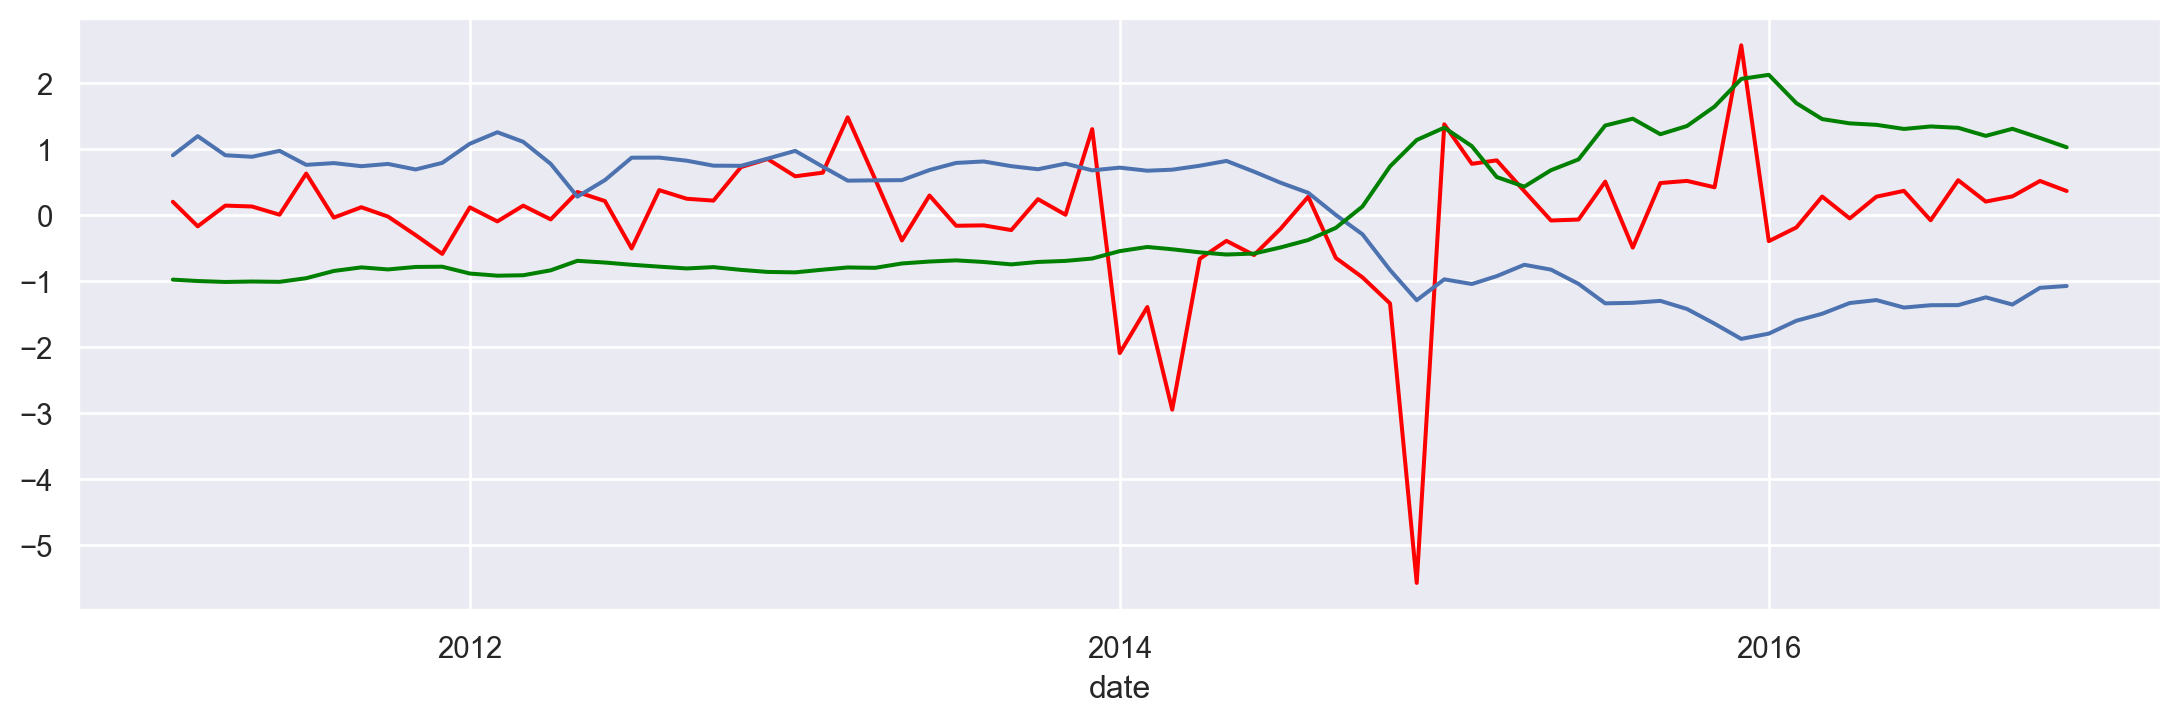

In [41]:
f = mpl.figure.Figure(figsize=(14, 4))
so.Plot().on(f).plot()
ax = f.axes[0]

so.Plot(x=rel_target.index,y=rel_target.target_resid).add(so.Lines(color='red')).on(ax).plot()
so.Plot(x=rel_target.index,y=rel_target.oil).add(so.Lines()).on(ax).plot()
so.Plot(x=rel_target.index,y=rel_target.exchange).add(so.Lines(color='green')).label(title='', y='').on(ax).plot()

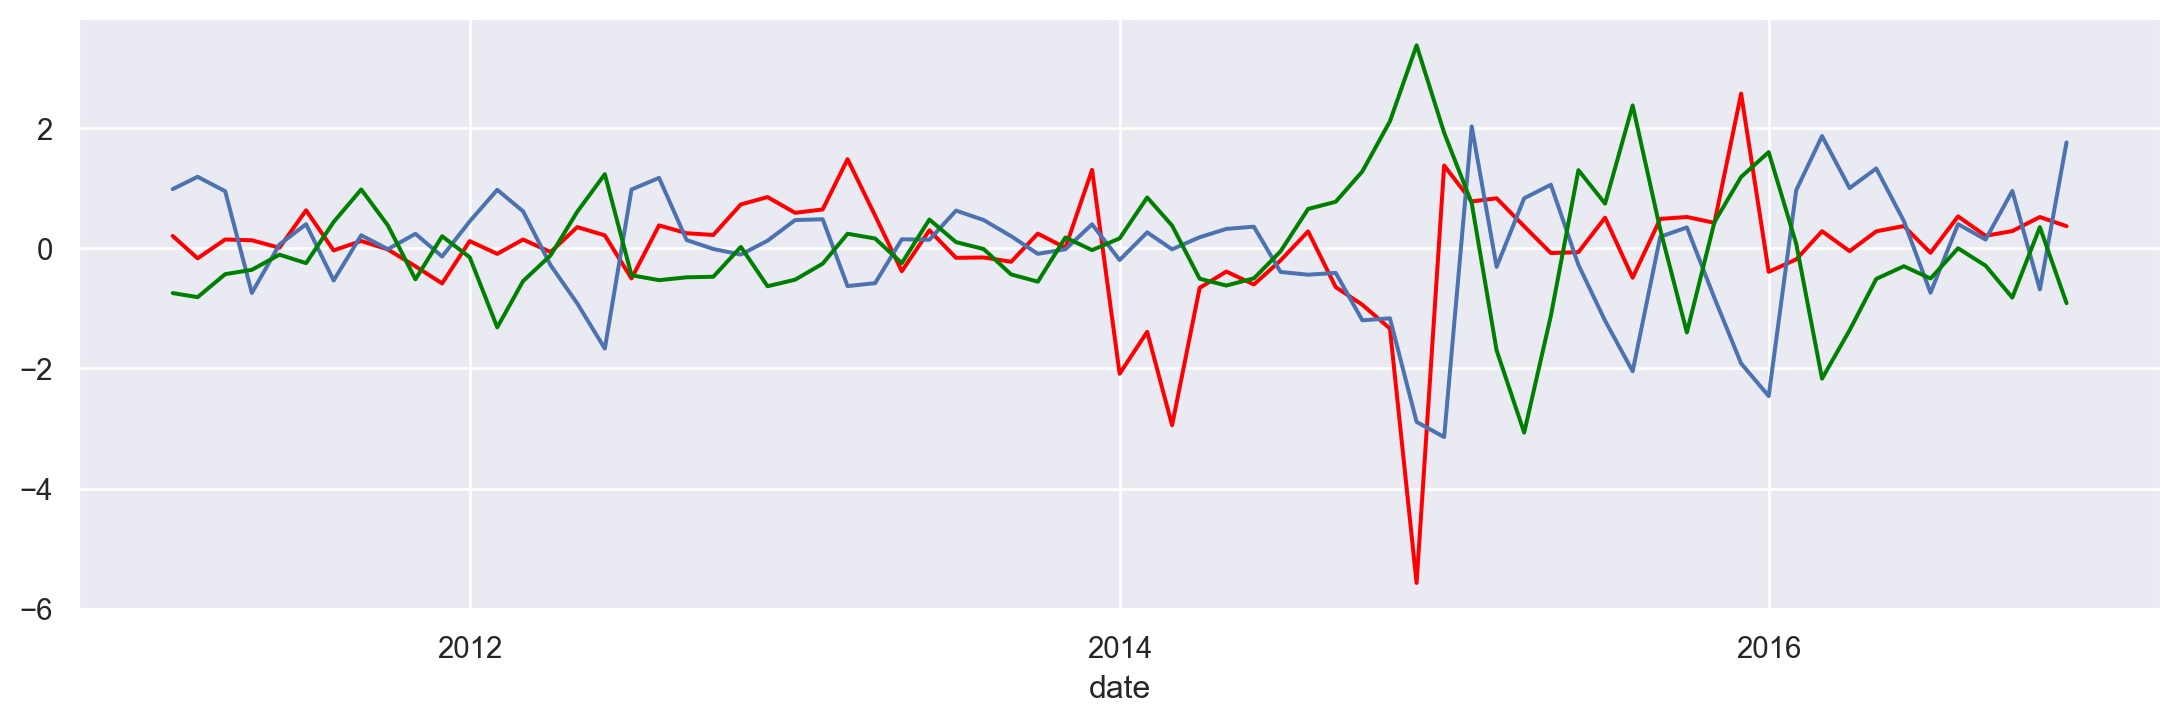

In [42]:
f = mpl.figure.Figure(figsize=(14, 4))
so.Plot().on(f).plot()
ax = f.axes[0]

so.Plot(x=rel_target.index,y=rel_target.target_resid).add(so.Lines(color='red')).on(ax).plot()
so.Plot(x=rel_target.index,y=rel_target.oil_dif).add(so.Lines()).on(ax).plot()
so.Plot(x=rel_target.index,y=rel_target.exchange_dif).add(so.Lines(color='green')).label(title='', y='').on(ax).plot()

*Данные отмасштабированы по оси Y*

На первом графике - абсолютные значения, на втором - прирост за месяц:
- Зеленая линия - курс рубля по отношению к доллару
- Синяя линия - цена на нефть марки Urals
- Красная линия - прирост вкладов, с поправкой на сезонность


На экономический кризис 2014-2015 гг. в РФ также повлияло снижение цен на нефть, как следствие девальвация рубля.

Похоже линейная зависимость между приростом вкладов и изменением цен на нефть и курсом рубля слабая.

Возможно, данный эффект обуславливается непрямым воздействием на зависимую переменную.

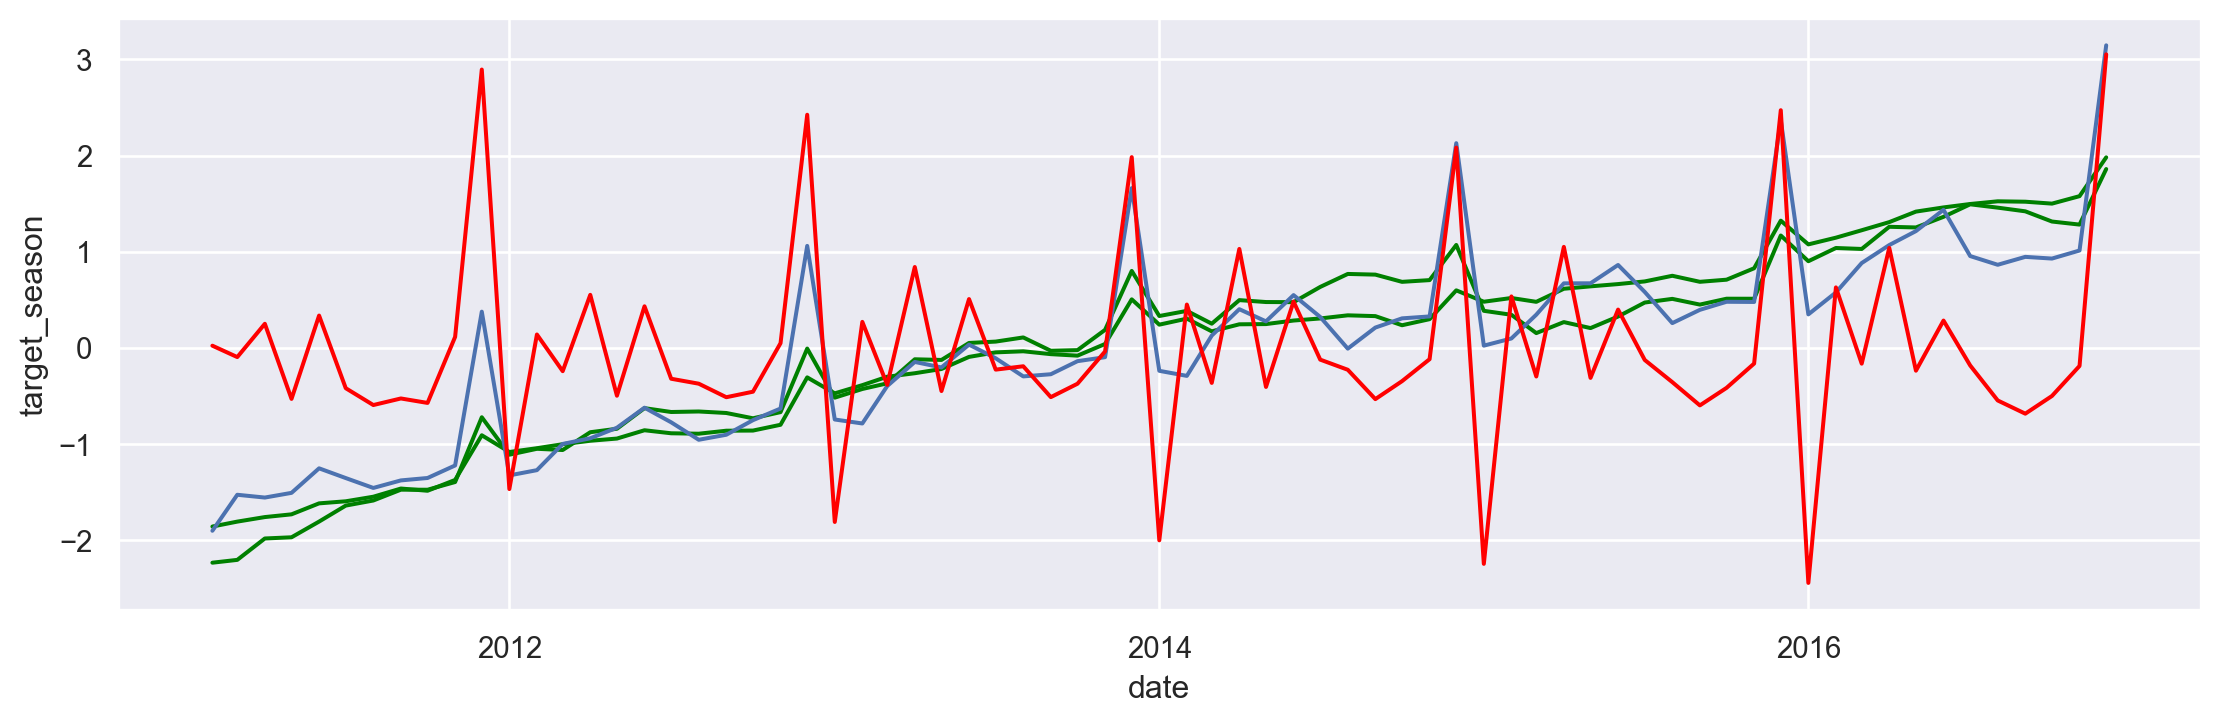

In [43]:
f = mpl.figure.Figure(figsize=(14, 4))
so.Plot().on(f).plot()
ax = f.axes[0]


so.Plot(x=rel_target.index,y=rel_target.m0).add(so.Lines(color='green')).on(ax).plot()
so.Plot(x=rel_target.index,y=rel_target.m2).add(so.Lines(color='green')).on(ax).plot()
so.Plot(x=rel_target.index,y=rel_target.salary).add(so.Lines()).on(ax).plot()
so.Plot(x=rel_target.index,y=rel_target.target_season).add(so.Lines(color='red')).on(ax).plot()

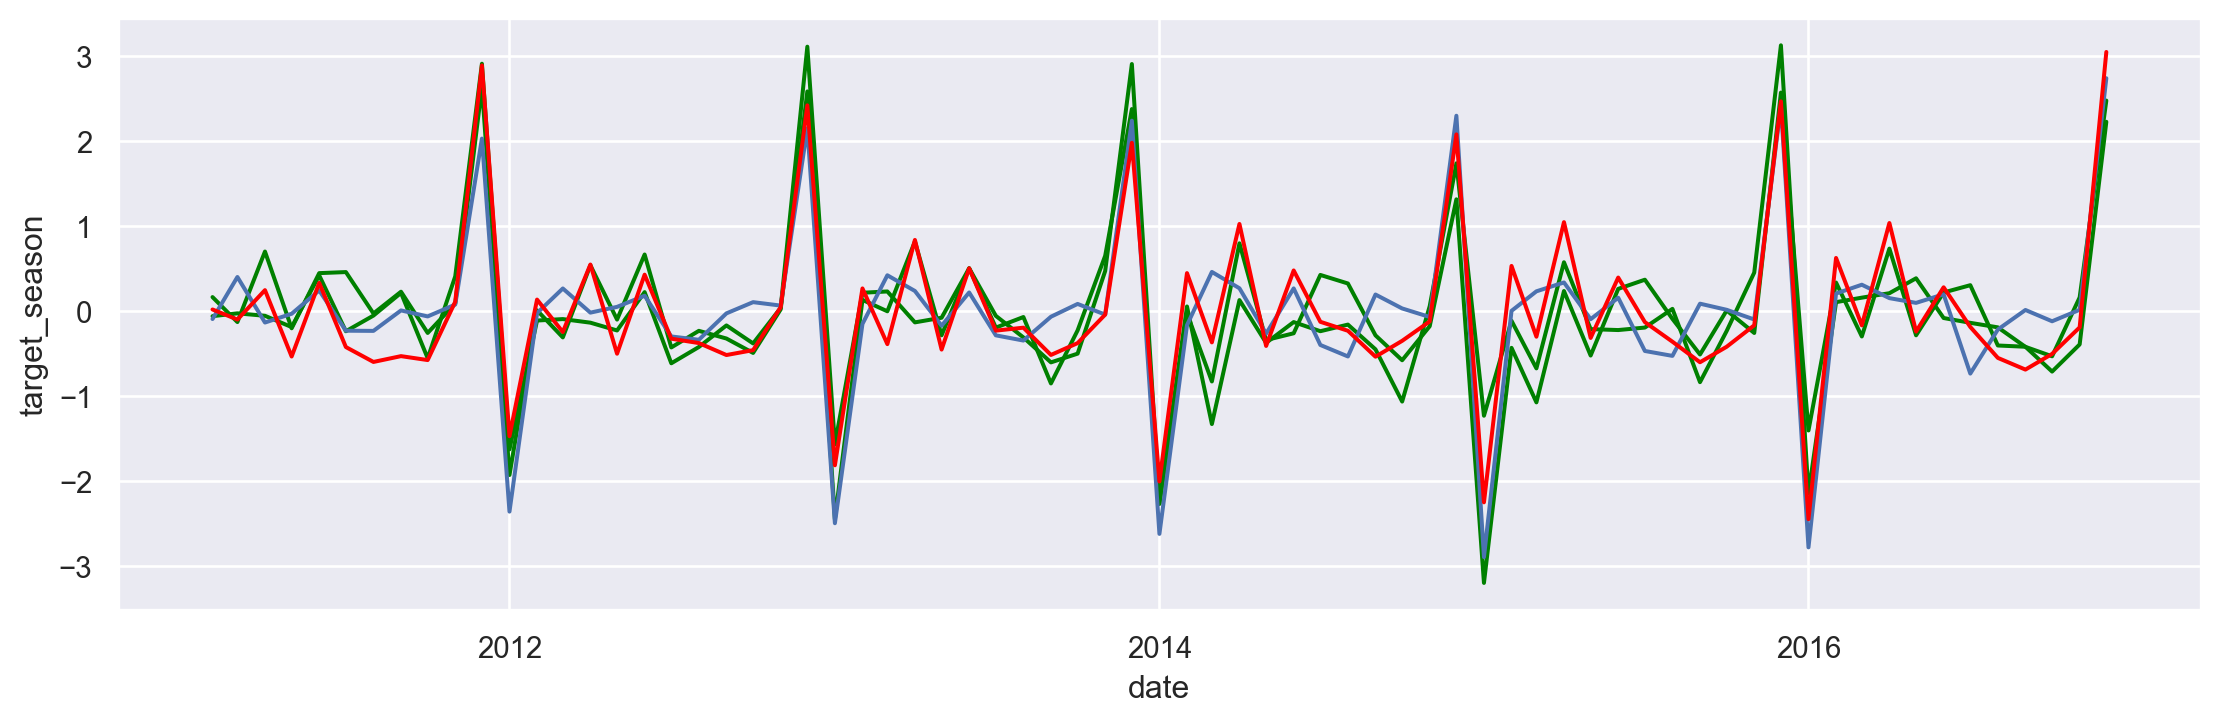

In [44]:
f = mpl.figure.Figure(figsize=(14, 4))
so.Plot().on(f).plot()
ax = f.axes[0]


so.Plot(x=rel_target.index,y=rel_target.m0_dif).add(so.Lines(color='green')).on(ax).plot()
so.Plot(x=rel_target.index,y=rel_target.m2_dif).add(so.Lines(color='green')).on(ax).plot()
so.Plot(x=rel_target.index,y=rel_target.salary_dif).add(so.Lines()).on(ax).plot()
so.Plot(x=rel_target.index,y=rel_target.target_season).add(so.Lines(color='red')).on(ax).plot()

*Данные отмасштабированы по оси Y*

На первом графике - абсолютные значения, на втором - прирост за месяц:

- Зеленые линии - скорость изменения обращения денежной массы (агрегаторы M0 и М2)
- Синяя линия - скорость изменения заработной платы
- Красная линия - прирост вкладов, с поправкой на сезонность

Число вкладов также обуславливается уровнем заработной платы и скоростью обращения наличных и безналичных денежных средств, что подтверждается графиком выше.

#### Correlations

In [45]:
seasons = ['m0','m2','salary','m0_dif','m2_dif','salary_dif']

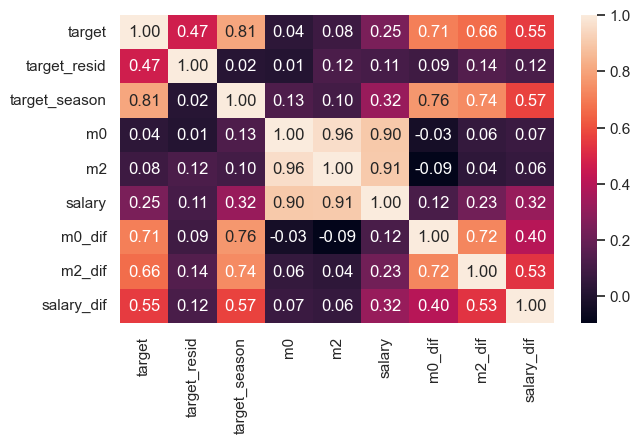

In [68]:
fig, ax = plt.subplots(figsize=(7,4))
sns.heatmap(rel_target[['target', 'target_resid', 'target_season']+seasons].corr('spearman'), annot=True, fmt=".2f", ax=ax) # cmap=sns.color_palette("vlag", as_cmap=True)
plt.show()

*Постфикс "diff" у переменных, которые продифференцированы (прирост).*

- корреляция целевой переменной наиболее сильная с дифференцированными переменными;
- корреляция переменной сезонности таргета сильнее связана с предикторами, чем сам таргет;
- связь целевой переменной с М0, М2 и заработной платой - сильная, положительная;
- связь переменных  М0, М2 и заработной платой между собой также сильная, положительная;
- мультиколлинеарность между переменными М0 и М2.

### Препроцессинг

In [47]:
other = rel_target.drop(['target', 'target_resid', 'target_season']+seasons, axis=1).columns.to_list()

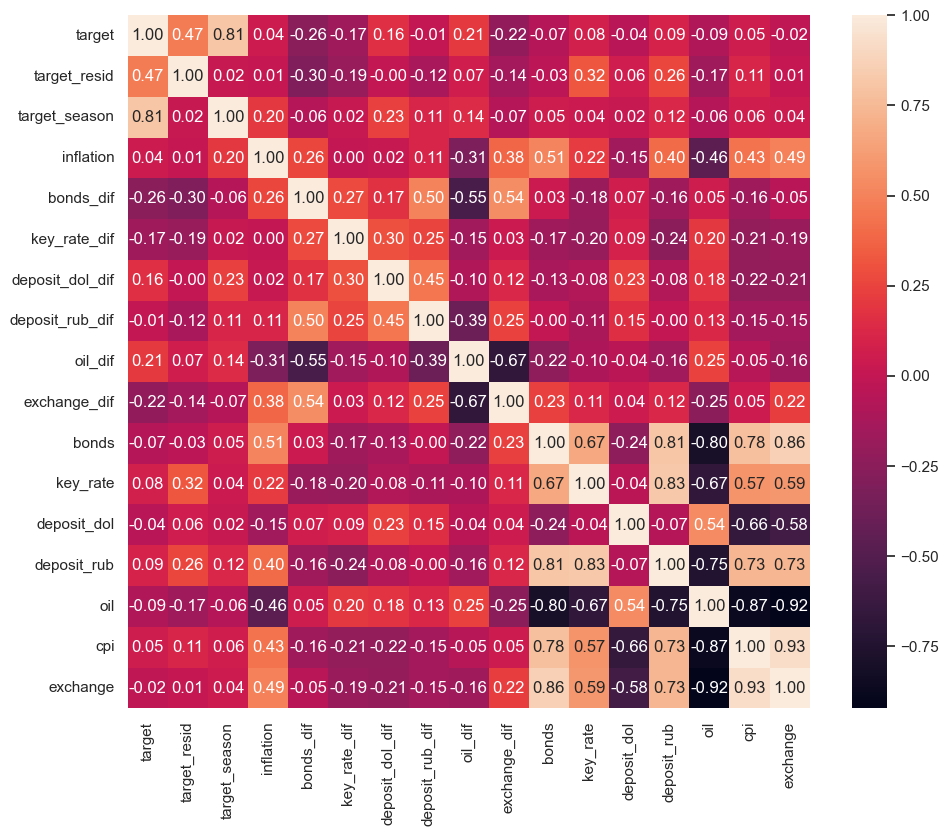

In [67]:
fig, ax = plt.subplots(figsize=(11,9))
sns.heatmap(rel_target[['target', 'target_resid', 'target_season']+other].corr('spearman'), annot=True, fmt=".2f", ax=ax) # cmap=sns.color_palette("vlag", as_cmap=True)
plt.show()

*Постфикс "diff" у переменных, которые продифференцированы (прирост).*

- связь таргета с предикторами статистически слабая, или отсутствует;
- связь предикторов между собой очень сильная;
- мультиколлинеарность между ценами на нефть и курсом рубля.

Статистически прирост вкладов связан с сезонностью больше, чем с макроэкономическими показателями.

# Модель

1. Для данного анализа я попробую предсказать сезонность с помощью **тройного экпоненциального сглаживания**.

2. Остатки попробую предсказать с помощью **регрессионной модели** и **деревянной модели**.

Качество моделей: ***RMSE*** и $ R^{2}$

### Препроцессинг

In [49]:
# valid = target.drop(seasons, axis=1).loc['2017-01-01':].dropna(axis=1)
# train = target.drop(seasons, axis=1).loc[:'2016-12-01'].dropna()
valid = target.drop(['target_season','target'], axis=1).loc['2017-01-01':].dropna(axis=1)
train = target.drop(['target_season','target'], axis=1).loc[:'2016-12-01'].dropna(axis=0)
train['year']=train.index.year
valid['year']=valid.index.year
train['month']=train.index.month
valid['month']=valid.index.month

In [50]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

train_index = []
test_index = []
for i, (train_i, test_i) in enumerate(tscv.split(train)):
    train_index.append(train_i)
    test_index.append(test_i)

### Экспоненциальное сглаживание

In [73]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

fit = ExponentialSmoothing(target.target_season.dropna(), seasonal='add', seasonal_periods=12).fit()

In [52]:
train['target_previous_year'] = train.target.shift(12)

AttributeError: 'DataFrame' object has no attribute 'target'

In [ ]:
autocorr = pd.DataFrame({
    'target': df.target,
    'target_previous_year': df.target.shift(12)})

In [ ]:
f = mpl.figure.Figure(figsize=(14, 4))
p1 = so.Plot(x=autocorr.index, y=autocorr.target).add(so.Lines()).label(title='', x='', y='')
p1.on(f).plot()

ax = f.axes[0]
p2 = so.Plot(x=autocorr.index, y=autocorr.shift_year).add(so.Lines(color='red')).label(title='', x='', y='')
p2.on(ax).plot()

In [ ]:
autocorr = autocorr.dropna()

while all((np.abs(st.zscore(autocorr)) >= 3).sum() > 0):
    autocorr = autocorr[(np.abs(st.zscore(autocorr)) < 3).all(axis=1)]

In [ ]:
so.Plot(autocorr, x='target', y='shift_year').add(so.Dots()).label(title='', x='', y='')

In [ ]:
print(is_norm(autocorr.target.dropna()))

In [ ]:
print(st.spearmanr(autocorr.dropna().target, autocorr.dropna().shift_year))

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

acf = plot_acf(stl.seasonal.dropna(), ax=ax1, lags=12)
pacf = plot_pacf(stl.seasonal.dropna(), ax=ax2, lags=12)

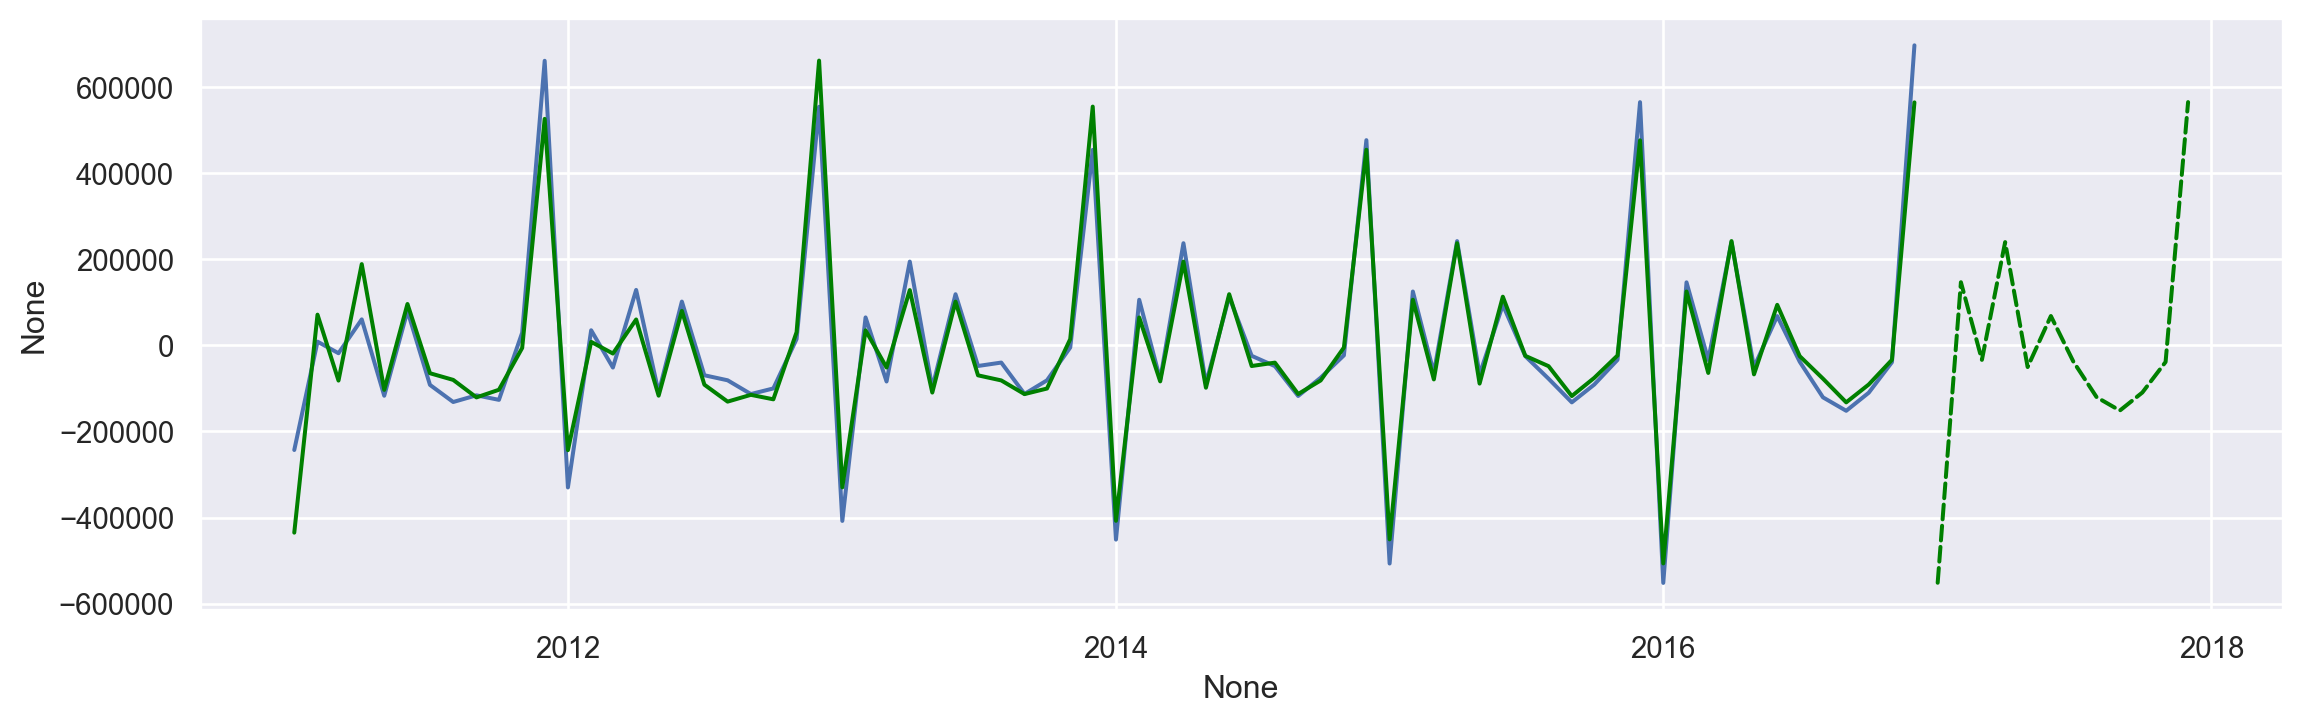

In [86]:
f = mpl.figure.Figure(figsize=(14, 4))
so.Plot().on(f).plot()
ax = f.axes[0]


so.Plot(x=target.target_season.dropna().index, y=target.target_season.dropna()).add(so.Lines()).on(ax).plot()
so.Plot(x=target.target_season.dropna().index, y=fit.fittedvalues).add(so.Lines(color='green')).on(ax).plot()
so.Plot(x=fit.forecast(12).index, y=fit.forecast(12)).add(so.Lines(color='green', linestyle='--')).on(ax).plot()

In [75]:
pd.DataFrame([fit.params['smoothing_level'], 
              fit.params['smoothing_trend'], 
              fit.params['damping_trend'],
              fit.params['smoothing_seasonal'],
              fit.params['initial_level'],
              fit.params['initial_trend'],
              mean_squared_error(fit.fittedvalues, target.target_season.dropna())**0.5,
              r2_score(fit.fittedvalues, target.target_season.dropna())], 
             index=[r"$\alpha$", r"$\beta$", r"$\phi$", r"$\gamma$", r"$l_0$", "$b_0$", "RMSE", "$R^2$"],
             columns=['Results'])

Results
$\alpha$      0.005000
$\beta$            NaN
$\phi$             NaN
$\gamma$      0.995000
$l_0$     -9711.425595
$b_0$              NaN
RMSE      50898.015819
$R^2$         0.944375

Тренд для данной модели не рассчитывается, так как зависимая переменная представляет собой стационарный временной ряд.

- Синяя линия - реальные значения
- Зеленая - предсказанные
- Пунктирная - прогноз на 2017 год.

Коэффициент детерминации очень высокий, что означает высокую точность модели.
В среднем модель ошибается на 50 898 млн., что скорее всего связано с недостаточной точностью в раннем периоде.

В модели Хольта Уинтерса будущие предсказания напрямую зависят от прошлых значений. 
Так, чтобы предсказать, например, значение прироста вкладов в январе 2017 года, нужно обратиться к показателю в январе 2016 года и умножить этот показатель на коэффициент сезонности. В данной модели это - 0.995.

Действительно, мы видим, что предсказанные значения каждого месяца 2017 года соответствуют значениям каждого месяца прошлых лет. Если в январе в целом прирост вкладов отрицательный, то и в январе 2017 г. эта тенденция сохранится.

In [87]:
pred_target = pd.concat([fit.fittedvalues, fit.forecast(12)])

## Линейная регрессия

Для построения линейной регрессии вначале будут использованы все предикторы.
Далее из модели будут исключаться переменные, которые наименее всего превносят вклад.

In [125]:
formula = '+'.join(train.columns).replace('target_resid+','target_resid~').replace('month','C(month)')

ols = smf.ols(formula, data=train).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:           target_resid   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     4.136
Date:                Thu, 19 Jan 2023   Prob (F-statistic):           2.22e-05
Time:                        07:15:22   Log-Likelihood:                -881.10
No. Observations:                  71   AIC:                             1828.
Df Residuals:                      38   BIC:                             1903.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -9.735e+08    5.7e+08     

In [134]:
ols2 = smf.ols('target_resid~key_rate_dif+m2_dif+bonds', data=train).fit()
print(ols2.summary())

                            OLS Regression Results                            
Dep. Variable:           target_resid   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     25.67
Date:                Thu, 19 Jan 2023   Prob (F-statistic):           3.61e-11
Time:                        07:17:55   Log-Likelihood:                -907.20
No. Observations:                  71   AIC:                             1822.
Df Residuals:                      67   BIC:                             1831.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1.444e+05   3.87e+04      3.728   

In [135]:
ols3 = smf.ols('target_resid~key_rate_dif+m2_dif', data=train).fit()
print(ols3.summary())

                            OLS Regression Results                            
Dep. Variable:           target_resid   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     39.00
Date:                Thu, 19 Jan 2023   Prob (F-statistic):           5.23e-12
Time:                        07:18:06   Log-Likelihood:                -907.24
No. Observations:                  71   AIC:                             1820.
Df Residuals:                      68   BIC:                             1827.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1.344e+05   1.12e+04     12.038   

Обратим внимание только на последнюю модель.

Из всего набора данных наиболее важными оказались только 2 переменные - ключевая ставка и денежный агрегат М2.
Это неудивительно, так как переменные, которые включены в модель изначально тесно связаны с ключевой ставкой.
По видимому, из всех имеющихся данных достаточно только этих двух переменных, чтобы сделать прогноз.

Удивительно, что цена на нефть и курс рубля в данную модель вклад не вносят, хотя они являются причинами экономического кризиса 2014-2015 гг. и в целом являются одними индикаторов экономической стабильности.
Чтобы оценить истинное влияние цены на нефть и курса рубля, необходимо провести дополнительный анализ, что требует дополнительного времени.

Предполагалось, что повышение ключевой ставки ведет к снижению числа вкладов. 
Данная модель подтверждает гипотезу: при повышении ключевой ставки на 1 % прирост вкладов снижается на 86 940 млн.

Предполагалось также, что повышение экономической активности населения, чему служит индикатором показатель M2, ведет также к повышению числа вкладов. Данную гипотезу модель также подтверждает: при повышении показателя M2 на 1 % по отношению к предыдущему месяцу, число вкладов повышается на 53 млн.

В целом точность модели средняя (коэффициент детерминации - 0.534).

Для оценки точности модели построим график реальных и предсказанных значений и проведем кросс валидацию.

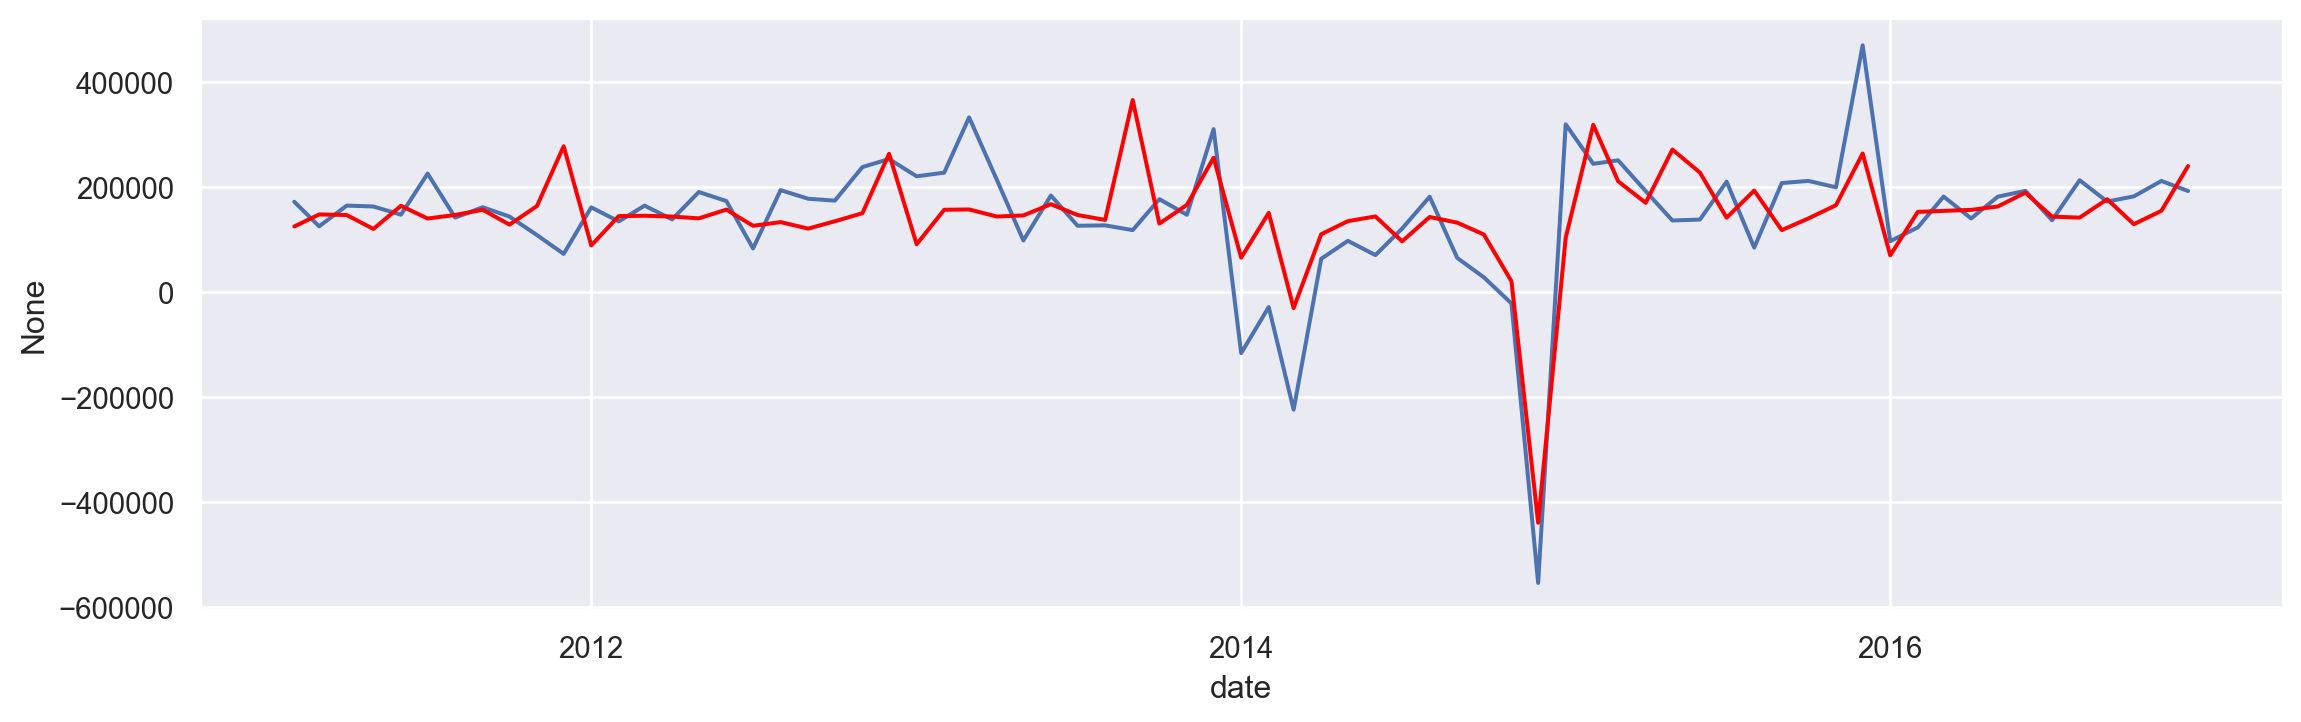

In [149]:
f = mpl.figure.Figure(figsize=(14, 4))
so.Plot().on(f).plot()
ax = f.axes[0]


so.Plot(x=train.target_resid.index, y=train.target_resid).add(so.Lines()).on(ax).plot()
so.Plot(x=train.target_resid.index, y=ols3.predict(train)).add(so.Lines(color='red')).on(ax).plot()

- красная линия - предсказанные значения
- синия линия - реальные

Мы видим, что модель хорошо реагирует на большие скачки, однако на небольших изменениях значения сильно расходятся от реальных.

In [181]:
overal=[]
for i, (train_i, test_i) in enumerate(tscv.split(train)):
    test_year = train.iloc[test_i].index.year.unique()[0]
    
    ols_small = smf.ols('target_resid~key_rate_dif+m2_dif', data=train.iloc[train_i]).fit()
    
    predictions = ols_small.predict(train.iloc[test_i].drop('target_resid', axis=1))
    predictions_target = pred_target.iloc[test_i+1]+predictions
    y_test = target.target.iloc[test_i+1]
    overal.append(predictions_target)
    print('='*12, f'Fold {i}. Test year {test_year}:', '='*12)
    print(f'target:    RMSE: {mean_squared_error(y_test, predictions_target)**0.5}, R2: {r2_score(y_test, predictions_target)}')
    print(f'residuals: RMSE: {mean_squared_error(train.iloc[test_i].target_resid, predictions)**0.5}, R2: {r2_score(y_test, predictions)}')
    print('')
    # print(predictions)

============ Fold 0. Test year 2012: ============
target:    RMSE: 83516.3207956021, R2: 0.8830227143835966
residuals: RMSE: 90192.70652343553, R2: -0.24381044639878668

============ Fold 1. Test year 2013: ============
target:    RMSE: 210914.53686380567, R2: 0.5536869476607114
residuals: RMSE: 213374.8034354575, R2: -0.24703831020022937

============ Fold 2. Test year 2014: ============
target:    RMSE: 155020.97994790194, R2: 0.0981914596370117
residuals: RMSE: 166402.2615887042, R2: 0.2246339409555539

============ Fold 3. Test year 2015: ============
target:    RMSE: 123781.70452556877, R2: 0.8659165391964502
residuals: RMSE: 102931.87189571041, R2: 0.13874790219769595

============ Fold 4. Test year 2016: ============
target:    RMSE: 40573.57421705604, R2: 0.9690103269517103
residuals: RMSE: 39194.83967048572, R2: 0.11248921190185956



Выше приведена кросс-валидация для оценки точности модели, где:
- "target" - оценка прогноза остатков с учетом прогноза сезонности 
- "residuals" - оценка прогноза остатков

В целом модель хорошо предсказывает прирост вкладов, однако это достигается за счет точности предсказания сезонности.
В 2016 году модель ошиблась на 40 573 млн.

Результат кросс-валидации:

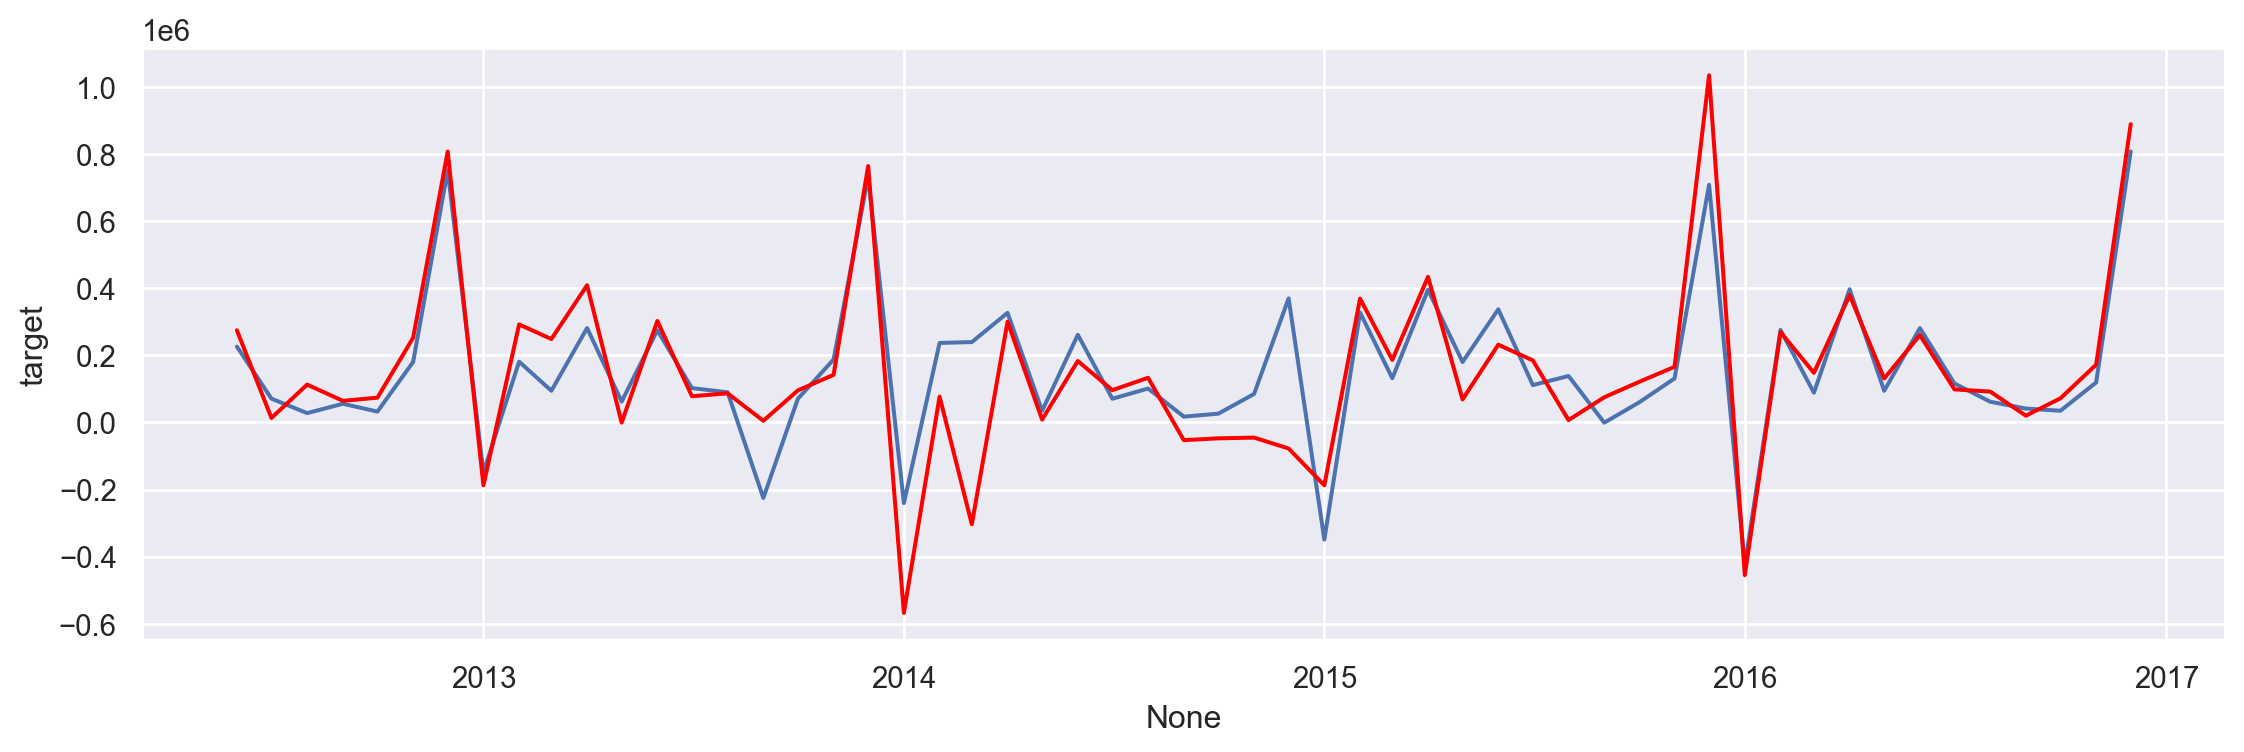

In [182]:
y_test = pd.concat([pd.concat(overal), target.target], axis=1).dropna()

f = mpl.figure.Figure(figsize=(14, 4))
so.Plot().on(f).plot()
ax = f.axes[0]

so.Plot(x=y_test.index, y=y_test[0]).add(so.Lines()).on(ax).plot()
so.Plot(x=y_test.index, y=y_test['target']).add(so.Lines(color='red')).on(ax).plot()

### Boosting

In [191]:
from catboost import CatBoostRegressor, Pool

train_pool = Pool(data=train.iloc[train_index[3]].drop('target_resid', axis=1),
                  label=train.iloc[train_index[3]].target_resid,
                  cat_features=['month'])
test_pool = Pool(data=train.iloc[test_index[3]].drop('target_resid', axis=1),
                  label=train.iloc[test_index[3]].target_resid,
                  cat_features=['month'])

In [234]:
cat = CatBoostRegressor(n_estimators=1000,
                        learning_rate=0.1,
                        has_time=True,
                        use_best_model=True,
                        verbose=False,
                        eval_metric='R2',
                        random_state=42,
                        max_depth=2)         # лучший показатель R2 с глубиной - 2

cat.fit(train_pool, eval_set=test_pool)

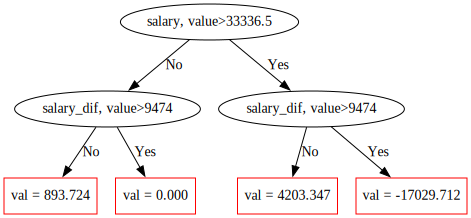

In [235]:
cat.plot_tree(0, train_pool)

Кросс-валидация
- "target" - оценка прогноза остатков с учетом прогноза сезонности 
- "residuals" - оценка прогноза остатков

In [277]:
overal_cat = []
for test_i in test_index:
    predictions = pd.Series(cat.predict(test_pool), index=train.iloc[test_i].index)
    predictions_target = pred_target.iloc[test_i+1]+predictions
    y_test = target.target[test_i+1]
    print('='*12, f'Fold {i}. Test year {test_year}:', '='*12)
    print(f'target:    RMSE: {mean_squared_error(y_test, predictions_target)**0.5}, R2: {r2_score(y_test, predictions_target)}')
    print(f'residuals: RMSE: {mean_squared_error(train.iloc[test_i].target_resid, predictions)**0.5}, R2: {r2_score(y_test, predictions)}')
    print('')
    overal_cat.append(predictions_target)

============ Fold 4. Test year 2016: ============
target:    RMSE: 95377.62434071663, R2: 0.8474360818501581
residuals: RMSE: 97614.72460255037, R2: -0.12163861461766601

============ Fold 4. Test year 2016: ============
target:    RMSE: 147389.28206732415, R2: 0.7820492502108797
residuals: RMSE: 150436.03216420606, R2: -0.050900261175034434

============ Fold 4. Test year 2016: ============
target:    RMSE: 221605.34855692709, R2: -0.8428664526500595
residuals: RMSE: 230642.02559051727, R2: -0.1661253819061126

============ Fold 4. Test year 2016: ============
target:    RMSE: 149506.03316495908, R2: 0.8043950997854149
residuals: RMSE: 122968.43649949587, R2: -0.04863895683182351

============ Fold 4. Test year 2016: ============
target:    RMSE: 72333.41799837863, R2: 0.901506304057581
residuals: RMSE: 51817.505079080554, R2: -0.1766120576836805



Точность предсказания высокая (0.90 %), однако меньше, чем методом линейной регрессии. Ошибка в 2016 году составила 72 333 млн.

В данную модель вошло 2 предиктора: 
- номинальная заработанная плата
- прирост номинальной заработанной платы

Максимальный и минимальный прирост вкладов (точнее остатков от прироста вкладов) зависит от уровня прироста заработной платы в ветке, где уровень зарплаты больше 33 336,5 руб. Причем, если прирост зарплаты в пред месяце составил больше 9 474 руб., то число вкладов уменьшится на 17 030 млн. и наоборот, увеличится на 4 203 млн. 

В ветке, где уровень заработной платы меньше 33 336,5 руб., прироста вкладов нет, если прирост зарплаты в пред. месяце высокий, и 893 млн., если прирост зарплаты в пред. месяце небольшой.

Интересно, что в данную модель также не вошла ключевая ставка и цена на нефть или курс рубля.

Результат кросс-валидации:

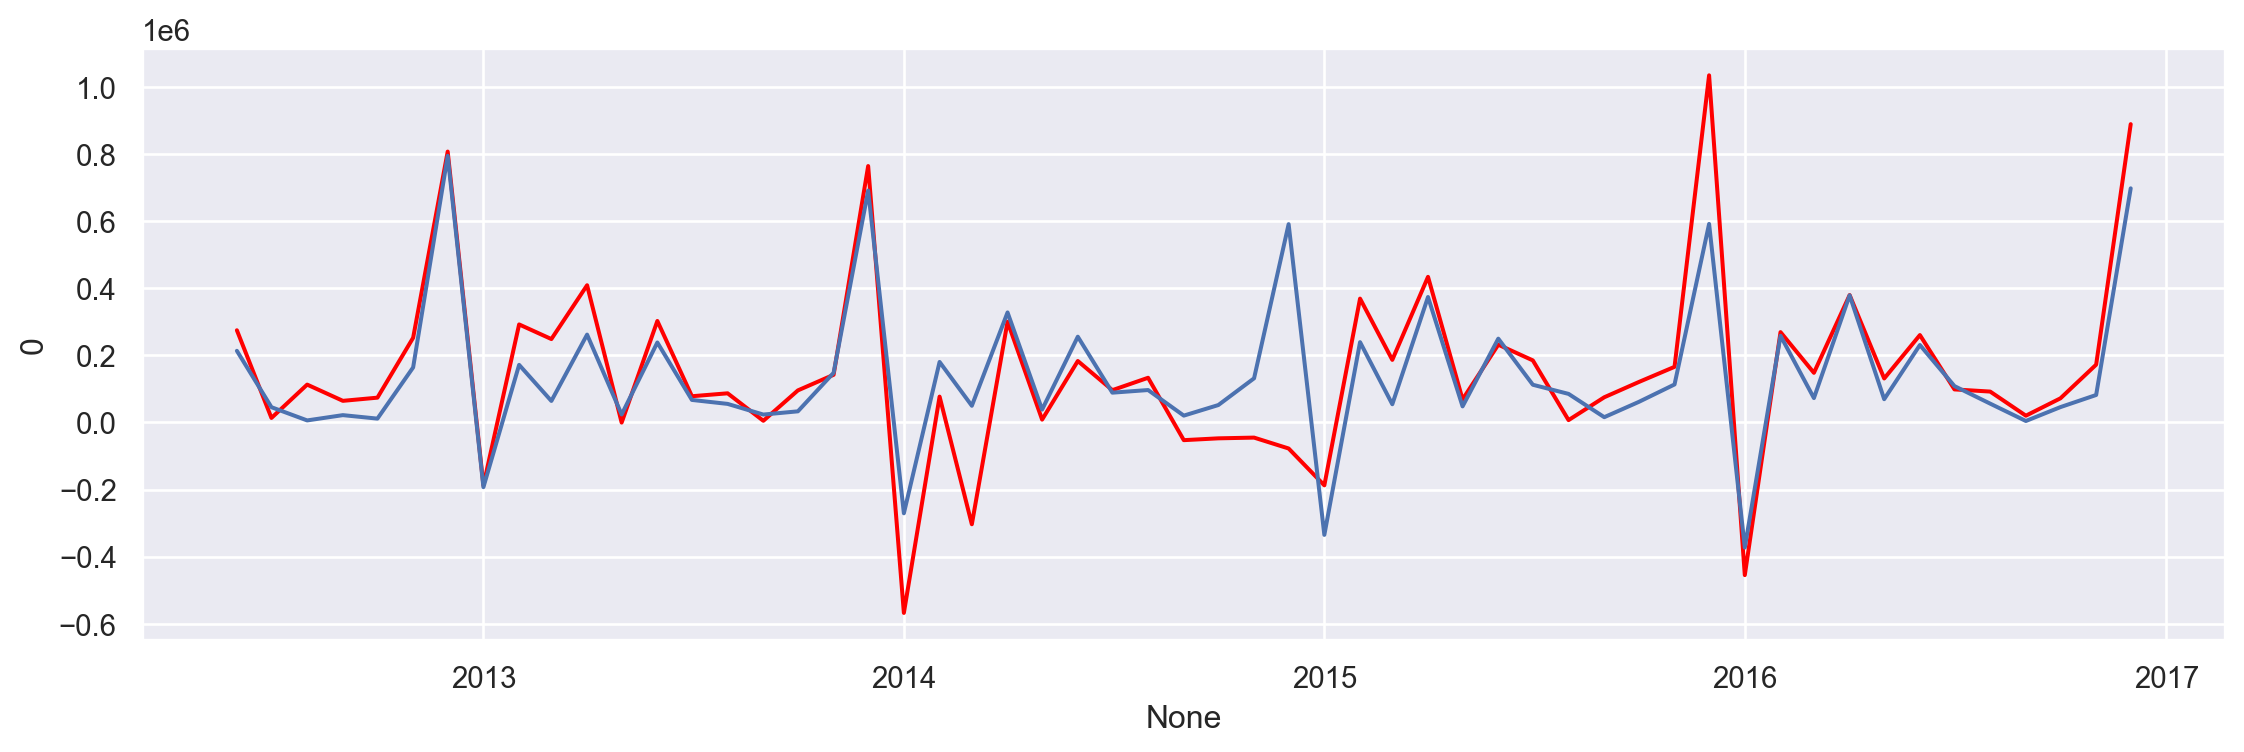

In [311]:
y_test = pd.concat([pd.concat(overal_cat), target.target], axis=1).dropna()

f = mpl.figure.Figure(figsize=(14, 4))
so.Plot().on(f).plot()
ax = f.axes[0]

so.Plot(x=y_test.index, y=y_test.target).add(so.Lines(color='red')).on(ax).plot()
so.Plot(x=y_test.index, y=y_test[0]).add(so.Lines()).on(ax).plot()

# Prediction

Для предсказания числа вкладов в 2017 году возьмем предсказания линейной регрессии, поскольку она дала лучшие результаты

In [324]:
pred1 = pred_target.loc[valid.index] + ols3.predict(valid)

In [325]:
submission.to_csv('submission.csv')

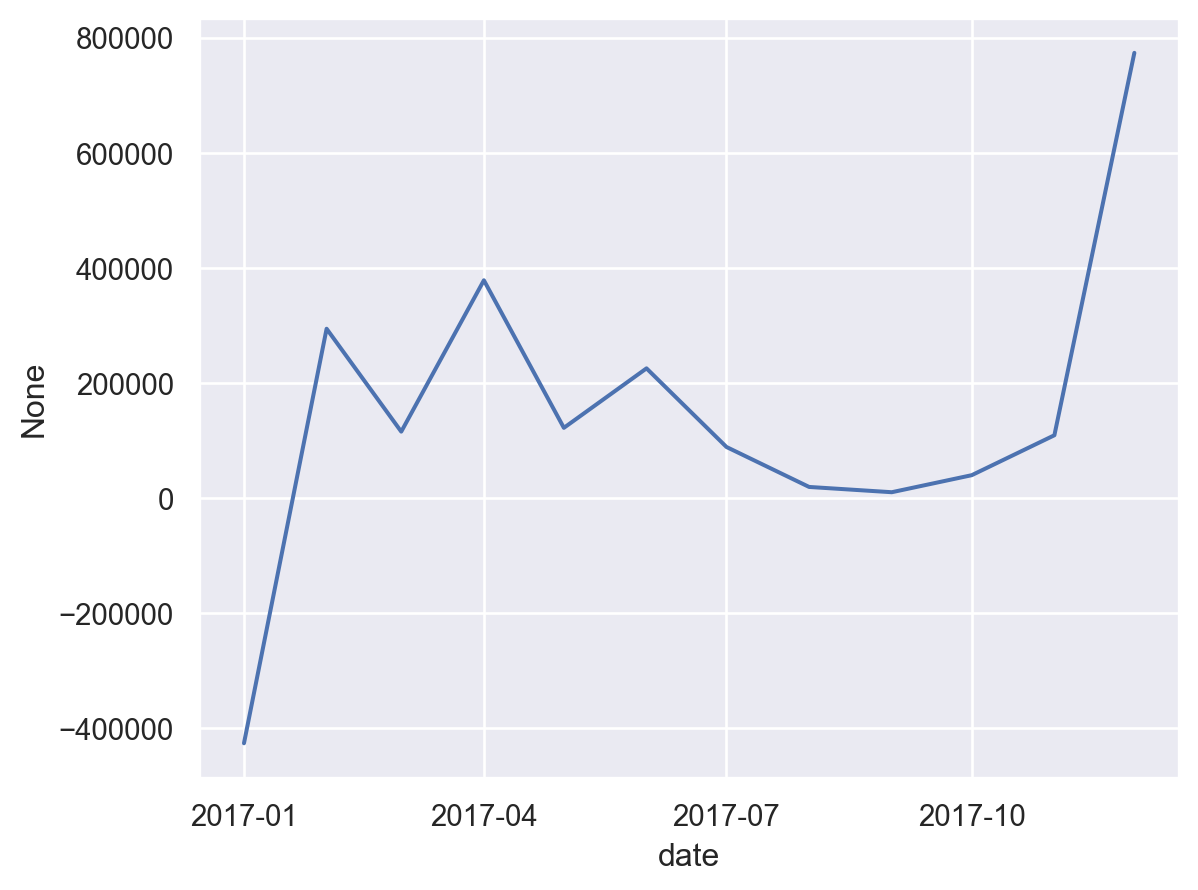

In [326]:
so.Plot(x=submission.index, y=submission).add(so.Lines())